# COVID-19 Data Analyses using New York Times Data

Note: The most up-to-date version of this notebook can be found in GitHub repository [bmc/covid19][].

The primary data source for this notebook is 
[COVID-19 data from The New York Times](https://github.com/nytimes/covid-19-data).

For additional data sources used, see [the README](https://github.com/bmc/covid19/blob/master/README.md)
in [bmc/covid19].

## Approach

This notebook loads the New York Times COVID-19 CSV files into [Pandas](https://pandas.pydata.org/) DataFrames. It
then manipulates, queries, and plots data via the DataFrames.

[bmc/covid19]: https://github.com/bmc/covid19/

## Imports and constants

In [1]:
import matplotlib
import matplotlib.pyplot as p
import numpy as np
import pandas as pd
from datetime import datetime, timedelta, date
import os
import sys
import re
import math
from pprint import pprint
from collections import namedtuple
from lib.common import *

print(f"Using Python {sys.version_info.major}.{sys.version_info.minor}.{sys.version_info.micro}")
print(f"Using matplotlib {matplotlib.__version__}")
print(f"Using Pandas {pd.__version__}")

Using Python 3.8.4
Using matplotlib 3.2.2
Using Pandas 1.0.5


In [2]:
NYTIMES_DIR_PATH = 'data/nytimes/covid-19-data'
US_DATA = os.path.join(NYTIMES_DIR_PATH, 'us.csv')
US_STATE_DATA = os.path.join(NYTIMES_DIR_PATH, 'us-states.csv')
US_COUNTY_DATA = os.path.join(NYTIMES_DIR_PATH, 'us-counties.csv')

In [3]:
METRIC_COLUMNS = {
    MetricType.DEATHS: 'deaths',
    MetricType.CASES: 'cases',
}

In [4]:
os.makedirs(IMAGES_PATH, exist_ok=True)
today = datetime.now().date()

## State population data

In [5]:
populations = load_united_states_population_data()
print(f"{populations['United States']:,}")

334,351,157


## Read the New York Times data

In [6]:
def read_nyt_data(path):
    """
    Reads one of the New York Times COVID-19 CSV files
    into a Pandas DataFrame, converting the date field
    to the appropriate type. Removes any records prior
    to April 12. Also adds a month_day string column.
    """
    df = pd.read_csv(path)
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
    df['month_day'] = df.apply(lambda row: row.date.date().strftime('%m/%d'), axis=1)
    cutoff = datetime(year=2020, month=4, day=12, hour=0, minute=0, second=0)
    return df.loc[df.date >= cutoff]

In [7]:
df_states = read_nyt_data(US_STATE_DATA)
print(f"Read data for {len(df_states.date.unique())} days.")
start_date = df_states.date.min()
end_date = df_states.date.max()
print(f"Starting date: {datestr(start_date.date(), include_year=True)}")
print(f"Ending date: {datestr(end_date.date(), include_year=True)}")

Read data for 102 days.
Starting date: 04/12/2020
Ending date: 07/22/2020


In [8]:
df_states

,date,state,fips,cases,deaths,month_day
2214,2020-04-12,Alabama,1,3583,93,04/12
2215,2020-04-12,Alaska,2,270,6,04/12
2216,2020-04-12,Arizona,4,3539,117,04/12
2217,2020-04-12,Arkansas,5,1280,27,04/12
2218,2020-04-12,California,6,23323,676,04/12
...,...,...,...,...,...,...
7819,2020-07-22,Virginia,51,80393,2051,07/22
7820,2020-07-22,Washington,53,51442,1534,07/22
7821,2020-07-22,West Virginia,54,5461,102,07/22
7822,2020-07-22,Wisconsin,55,48777,874,07/22


In [9]:
df_counties = read_nyt_data(US_COUNTY_DATA)
print(f"Read data for {len(df_counties.date.unique())} days.")
print(f"Starting date: {datestr(df_counties.date.min(), include_year=True)}")
print(f"Ending date: {datestr(df_counties.date.max(), include_year=True)}")

Read data for 102 days.
Starting date: 04/12/2020
Ending date: 07/22/2020


In [10]:
df_counties

,date,county,state,fips,cases,deaths,month_day
51069,2020-04-12,Autauga,Alabama,1001.0,19,1,04/12
51070,2020-04-12,Baldwin,Alabama,1003.0,71,1,04/12
51071,2020-04-12,Barbour,Alabama,1005.0,10,0,04/12
51072,2020-04-12,Bibb,Alabama,1007.0,16,0,04/12
51073,2020-04-12,Blount,Alabama,1009.0,13,0,04/12
...,...,...,...,...,...,...,...
359973,2020-07-22,Sweetwater,Wyoming,56037.0,201,2,07/22
359974,2020-07-22,Teton,Wyoming,56039.0,234,1,07/22
359975,2020-07-22,Uinta,Wyoming,56041.0,224,0,07/22
359976,2020-07-22,Washakie,Wyoming,56043.0,44,5,07/22


In [11]:
def plot_stats_by_date(df, metrics={MetricType.DEATHS}, per_n=1, population=None,
                       textbox_heading=None, textbox_loc=None, marker=None, 
                       figsize=(20, 12), image_file=None):
    """
    Takes a Pandas DataFrame with the Johns Hopkins data, groups the
    data by 'Month_Day' and sums up the values for all metrics. Then,
    plots the results. If an image file is specified, saves the plot in
    the appropriate image.
    
    Parameters:
    
    df              - The Pandas DataFrame to plot
    metrics         - A set containing the metrics to plot. Defaults to deaths.
                      Note that this data set has no statistics for hospitalizations
                      or tests; attempting to plot them will throw an error.
    per_n           - If set to 1, plot the data as is. Otherwise, do a per-capita
                      plot (i.e., number of X per n people). If per_n is not 1,
                      then population must be defined.
    population      - The population of the area (state, country) being plotted.
                      Only necessary if per_n is greater than 1.
    figsize         - The size of the plot.
    marker          - matplotlib marker to use for data points, or None.
    textbox_heading - An optional heading to add to the textbox annotation
    textbox_loc     - An (x, y) tuple for the location of the text box's top
                      left corner. Defaults to the upper left.
    image_file      - Name of image file in which to save plot, or None.
    """
    assert (per_n == 1) or (population is not None)
    
    SUPPORTED_METRICS = {MetricType.DEATHS, MetricType.CASES}

    assert metrics | SUPPORTED_METRICS == SUPPORTED_METRICS

    FirstLast = namedtuple('FirstLast', ('first', 'last'))

    def maybe_plot_metric(m, ax, df, first_last, errors):
        """
        Given a particular metric, calculate the appropriate data
        and, if the metric was specified, plot it.
        
        Parameters:
        m          - the metric (e.g., MetricType.DEATHS)
        ax         - the plot axis to use
        df         - the DataFrame to query
        first_last - the dictionary containing first and last values
                     for each metric. The key is a MetricType. The
                     value is a FirstLast object. The first and last
                     values for all metrics will be added here, even
                     if the metric isn't plotted.
        errors     - an array to which error messages can be appended
        """
        col = METRIC_COLUMNS[m]

        # Group the DataFrame by 'month_day', and sum up
        # the metric value. That gives us a grouping that sums
        # that value for all values for a given week. If the
        # DataFrame contains multiple state values, then they'll
        # all be summed up.
        group = df[col].groupby(df['month_day']).sum()

        if per_n > 1:
            group = group.apply(lambda sum: get_per_capita_float(sum, population))

        group_df = group.to_frame()
        first_value = int(round(group_df[col].iloc[0]))
        last_value = int(round(group_df[col].iloc[-1]))
        first_last[m] = FirstLast(first=first_value, last=last_value)

        if m in metrics:
            # Since these values are cumulative, if the last value is 0, we
            # can't trust the data.
            last_val = group_df[col].iloc[-1]
            if last_val <= 0:
                errors.append(f"No data for {METRIC_LABELS[m]} in this data set.")
            else:
                group.plot(x='month_day', y=col, ax=ax, figsize=figsize, color=METRIC_COLORS[m], marker=marker)

        return
    
    def build_text_for_texbox(first_last, start_date, end_date):
        """
        Builds the text block that will fill the explanatory
        text box in the plot.
        
        Parameters:
        
        first_last - the dictionary containing first and last values
                     for each metric. The key is a MetricType. The
                     value is a FirstLast object.
        start_date - the starting date, formatted as a string
        end_date   - the ending date, formatted as a string                     
        """
        def metric_summary_text(metric, first_last_dict, date_start, date_end):
            fl = first_last_dict[metric]
            label = METRIC_LABELS[metric]
            return f"{label}: {fl.first:,} ({date_start}) to {fl.last:,} ({date_end})"

        heading = f"{textbox_heading}: " if textbox_heading else ""
        text_lines = [f"{heading}{start_date} to {end_date}"]
        text_lines.append("\nValues represent running totals as of each\n"
                          "week, not totals just for that week.")
        if per_n > 1:
            text_lines.append(f"All numbers are per {per_n:,} people.")

        text_lines.append("")
        text_lines.append(metric_summary_text(MetricType.DEATHS, first_last, start_date, end_date))
        text_lines.append(metric_summary_text(MetricType.CASES, first_last, start_date, end_date))
        
        return '\n'.join(text_lines)

    # Main logic

    first_last = dict()
    errors = []

    # Make sure the DataFrame is sorted by Date, in case
    # it's been changed. Don't sort in place, though. Leave the 
    # original as is.
    df_by_date = df.sort_values(by=['date'], inplace=False)

    fig, ax = p.subplots(figsize=figsize)

    for m in SUPPORTED_METRICS:
        maybe_plot_metric(m, ax, df_by_date, first_last, errors)

    if len(metrics) > 1:
        ax.legend(loc='upper center')

    x_label = "Week\n\n(Source: New York Times)"
    ax.set_xlabel(x_label)

    y_label = ', '.join(METRIC_LABELS[m] for m in metrics)
    if per_n > 1:
        y_label = f"{y_label} per {per_n:,} people"
    ax.set_ylabel(y_label)

    # Build the explanatory text box.
    if len(errors) > 0:
        text_lines = ["ERROR: Can't plot all requested metrics.\n"]
        text_lines.extend(errors)
        text = '\n'.join(text_lines)
    else:
        start_date = df_by_date['date'].iloc[0].date().strftime('%B %d')
        end_date = df_by_date['date'].iloc[-1].date().strftime('%B %d')
        text = build_text_for_texbox(first_last, start_date, end_date)

    text_x, text_y = textbox_loc or (0.01, 0.98)
    textbox(ax, text_x, text_y, text)

    # Save the plot, if desired.
    if image_file is not None:
        fig.savefig(os.path.join(IMAGES_PATH, image_file))

    return None

## United States as a whole

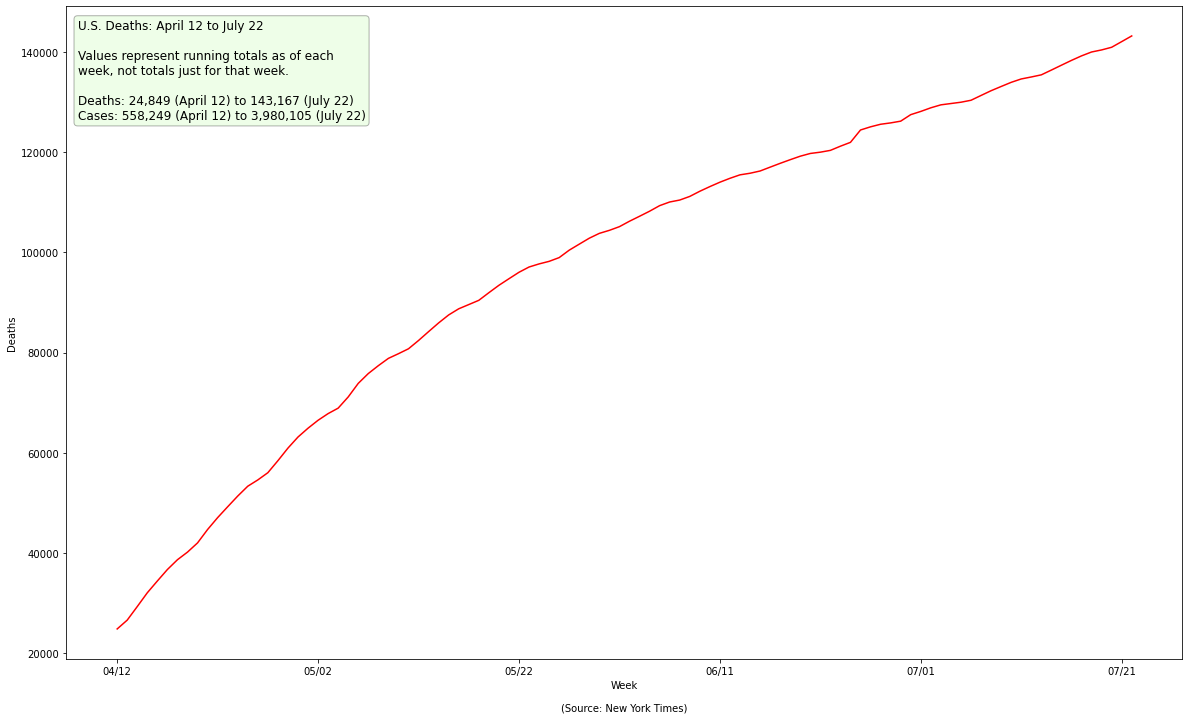

In [12]:
plot_stats_by_date(df_states, metrics={MetricType.DEATHS}, image_file='jhu-us-deaths.png', textbox_heading="U.S. Deaths")

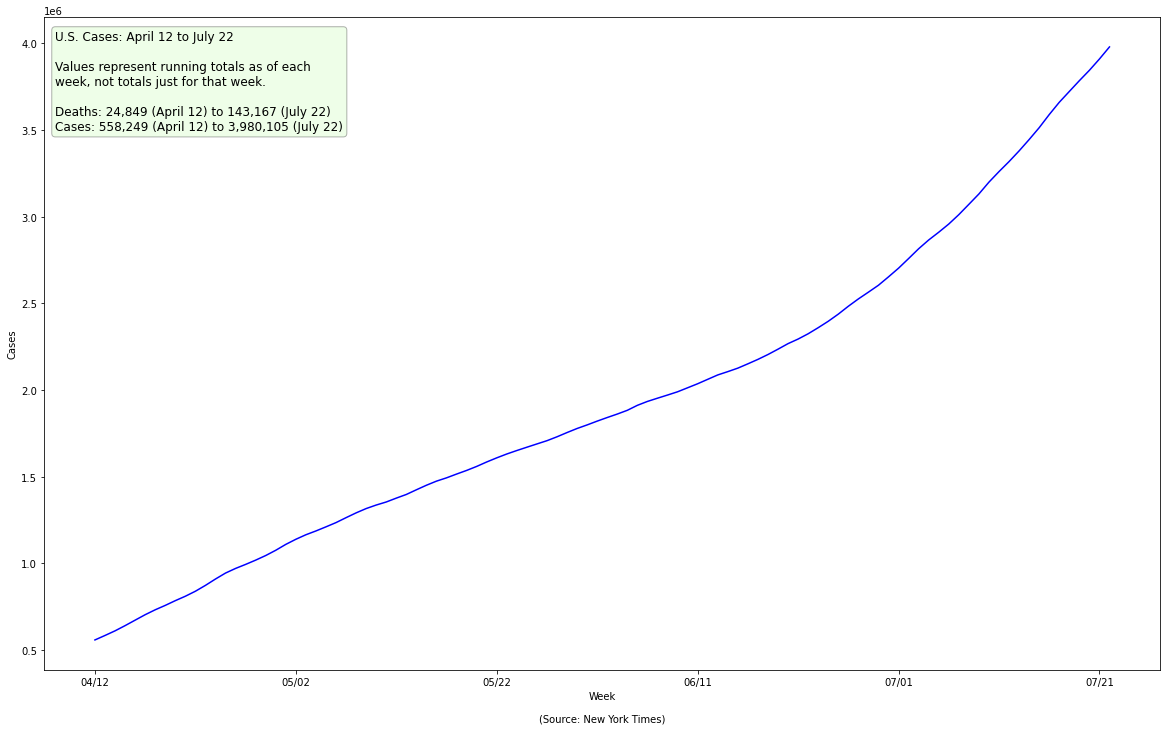

In [13]:
plot_stats_by_date(df_states, metrics={MetricType.CASES}, image_file='nyt-us-cases.png', textbox_heading="U.S. Cases")

### Just the past week

In [14]:
week_delta = timedelta(days=6)
six_days_prior = end_date - week_delta
last_week_start = date_to_datetime(six_days_prior)
last_week_end = date_to_datetime(end_date, hour=23, minute=59, second=59)

df_past_week = df_states.loc[(df_states.date >= last_week_start) & (df_states.date <= last_week_end)]

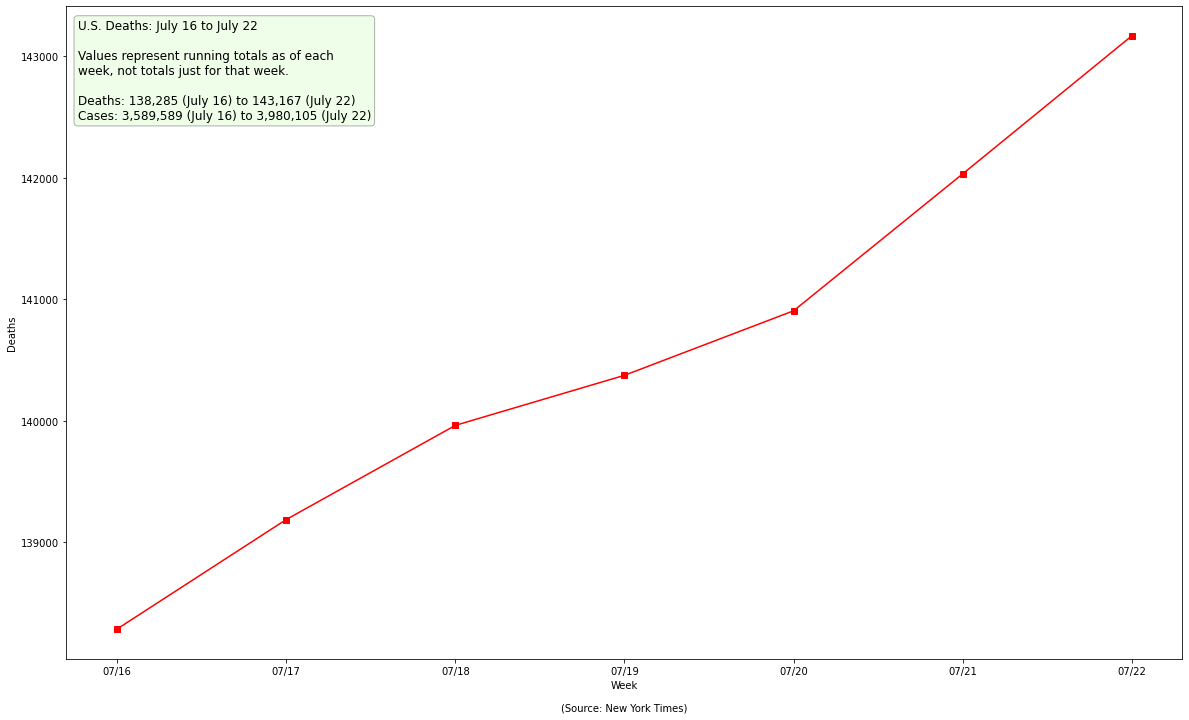

In [15]:
plot_stats_by_date(df_past_week, metrics={MetricType.DEATHS}, marker='s', 
                   textbox_heading="U.S. Deaths", image_file='nyt-us-deaths-past-week.png')

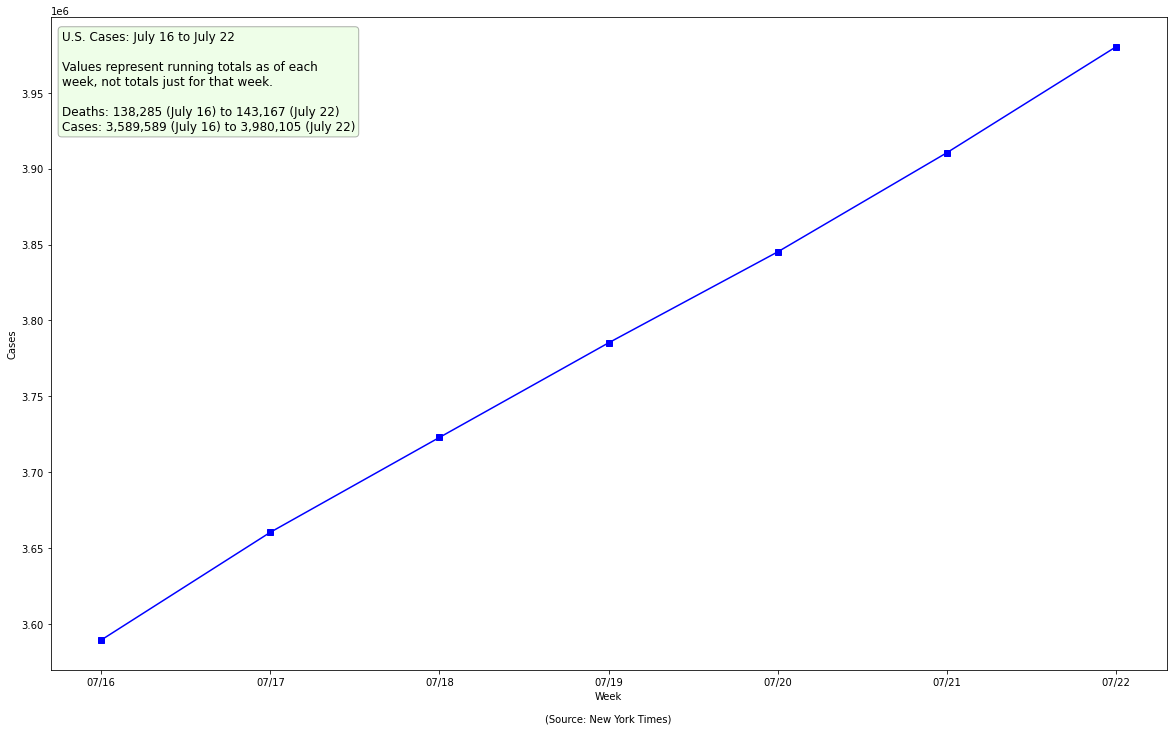

In [16]:
plot_stats_by_date(df_past_week, metrics={MetricType.CASES}, marker='s', 
                   textbox_heading="U.S. Cases", image_file='nyt-us-cases-past-week.png')

### Deaths vs. Cases

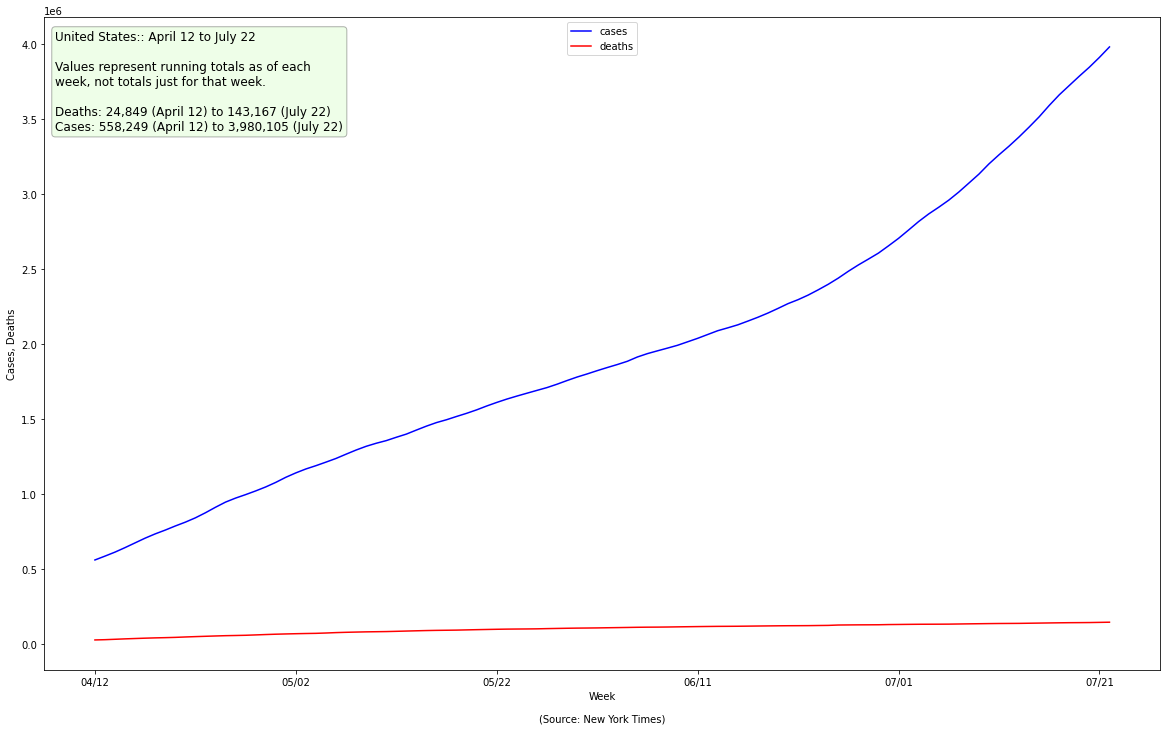

In [17]:
plot_stats_by_date(df_states, metrics={MetricType.DEATHS, MetricType.CASES}, textbox_heading="United States:",
                   image_file="nyt-us-deaths-and-cases.png")

## Individual States

In [18]:
def plot_state(df, state_name, image_file, metrics):
    df2 = df.loc[df.state == state_name]
    return plot_stats_by_date(df2, textbox_heading=state_name, image_file=image_file, metrics=metrics)

### Pennsylvania

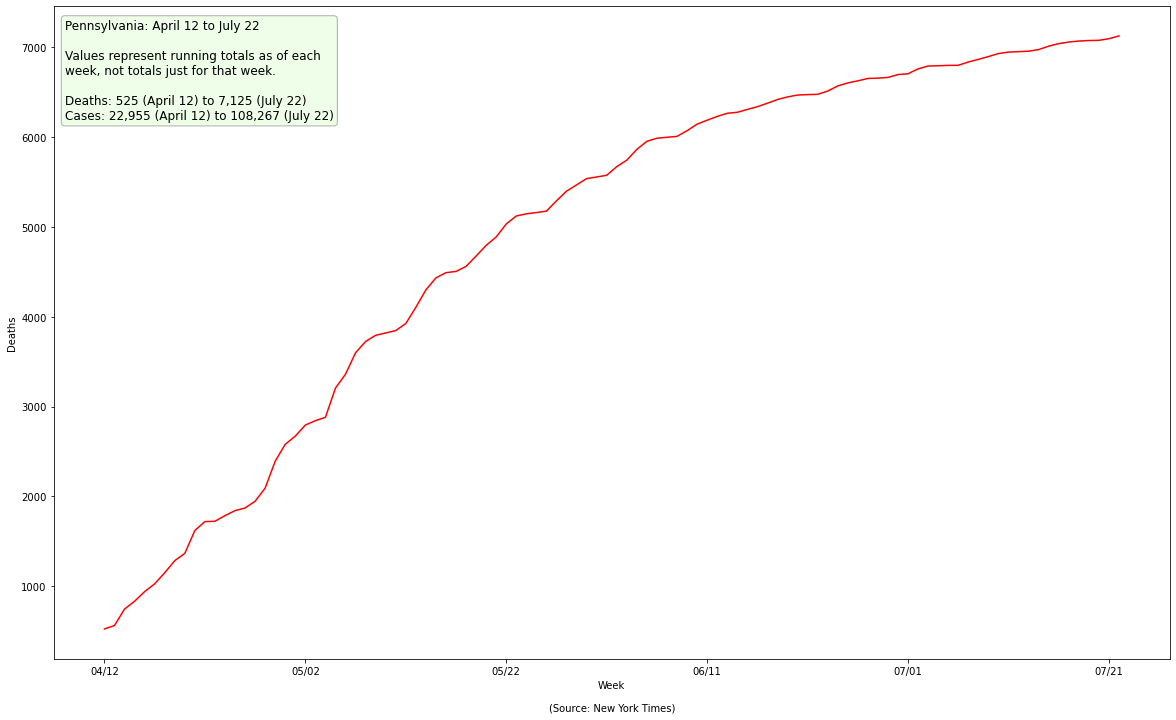

In [19]:
plot_state(df_states, 'Pennsylvania', image_file='nyt-pa-deaths.png', metrics={MetricType.DEATHS})

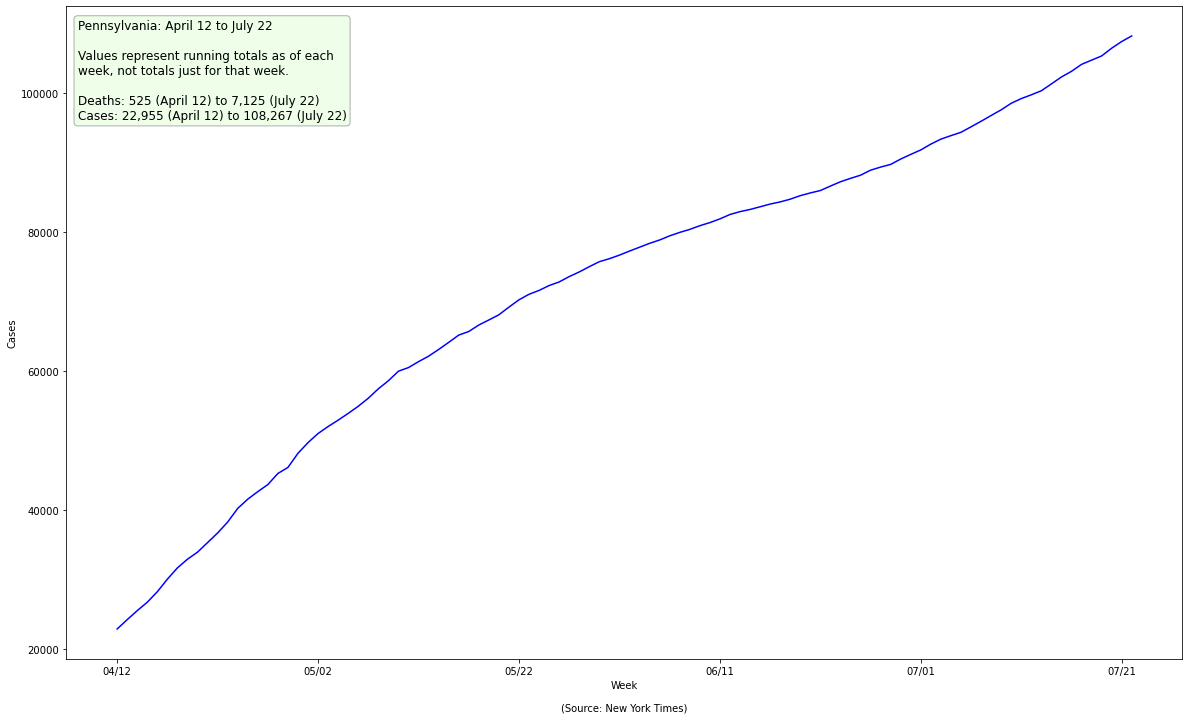

In [20]:
plot_state(df_states, 'Pennsylvania', image_file='nyt-pa-cases.png', metrics={MetricType.CASES})

### New York

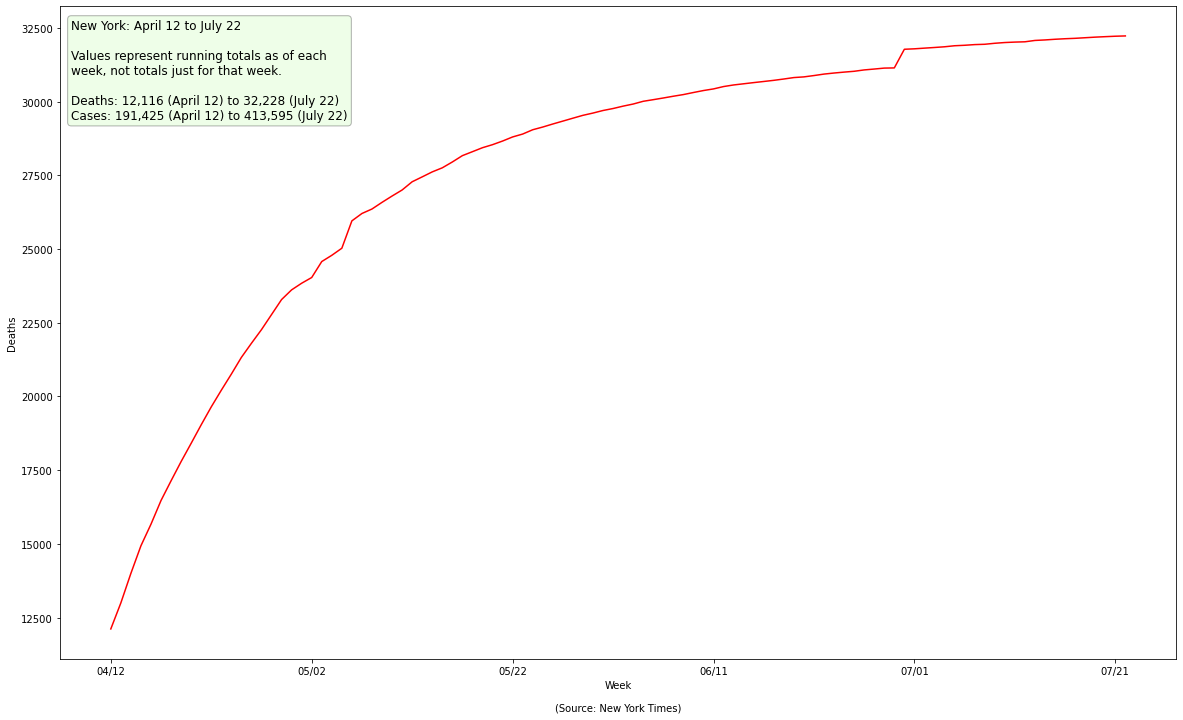

In [21]:
plot_state(df_states, 'New York', image_file='nyt-ny-deaths.png', metrics={MetricType.DEATHS})

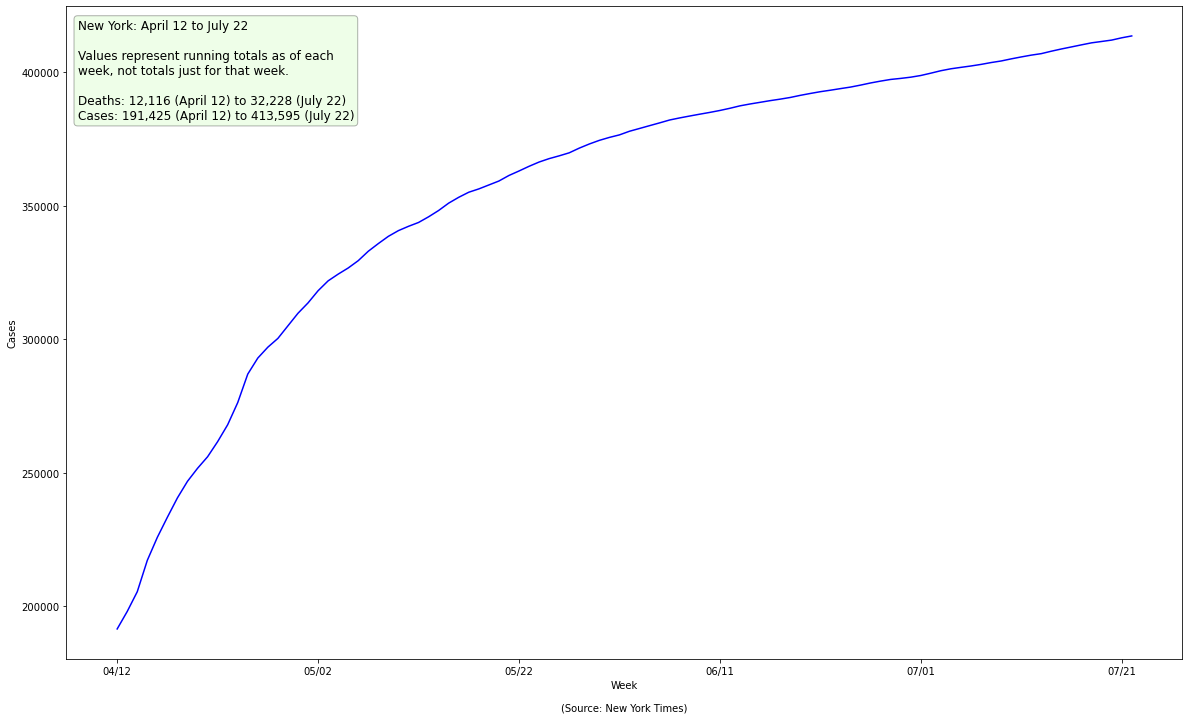

In [22]:
plot_state(df_states, 'New York', image_file='nyt-ny-deaths.png', metrics={MetricType.CASES})

### Washington

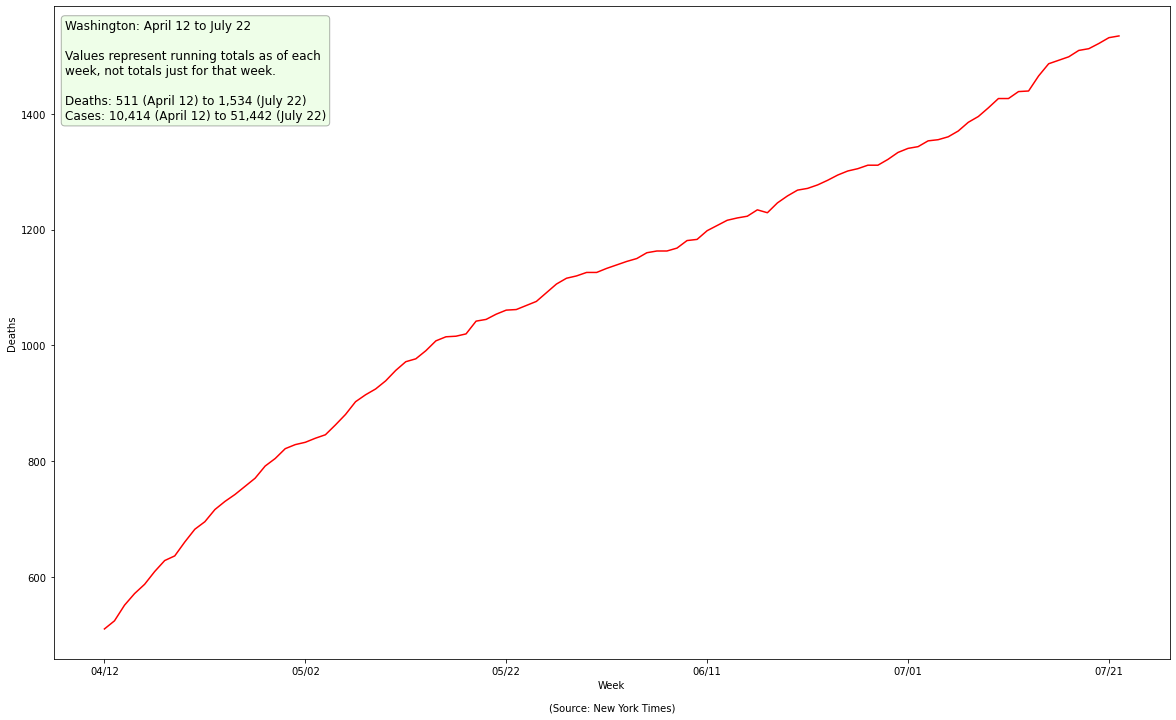

In [23]:
plot_state(df_states, 'Washington', image_file='nyt-wa-deaths.png', metrics={MetricType.DEATHS})

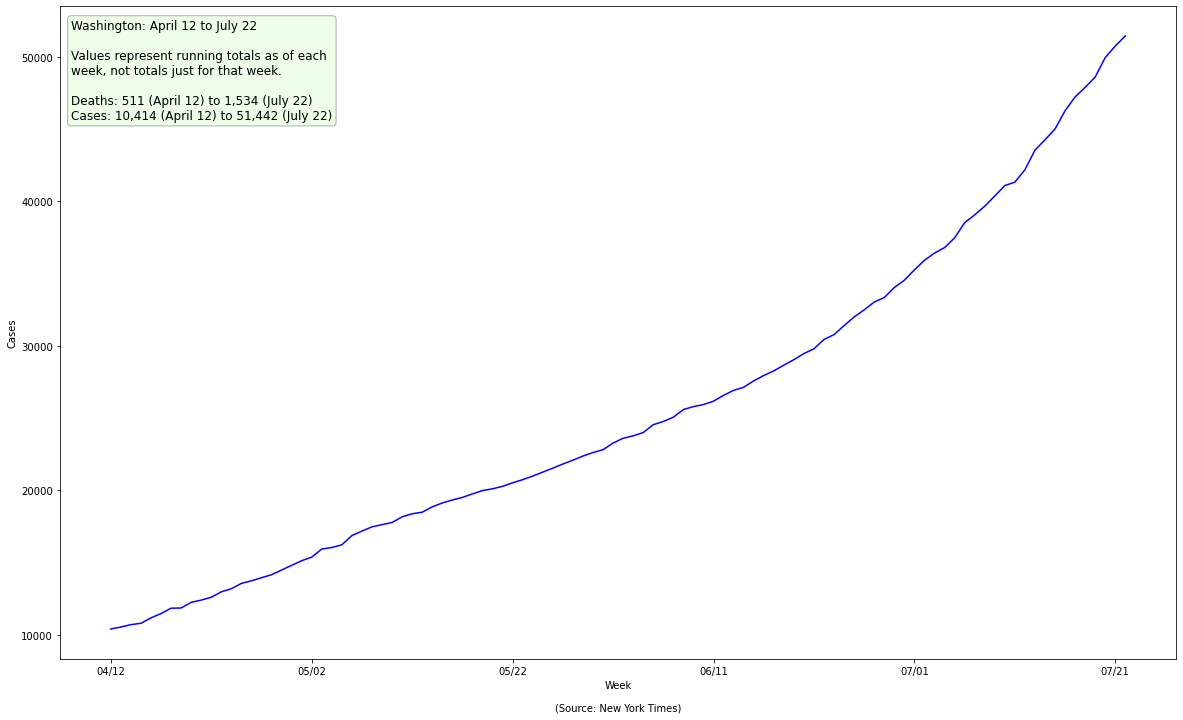

In [24]:
plot_state(df_states, 'Washington', image_file='nyt-wa-cases.png', metrics={MetricType.CASES})

### Delaware

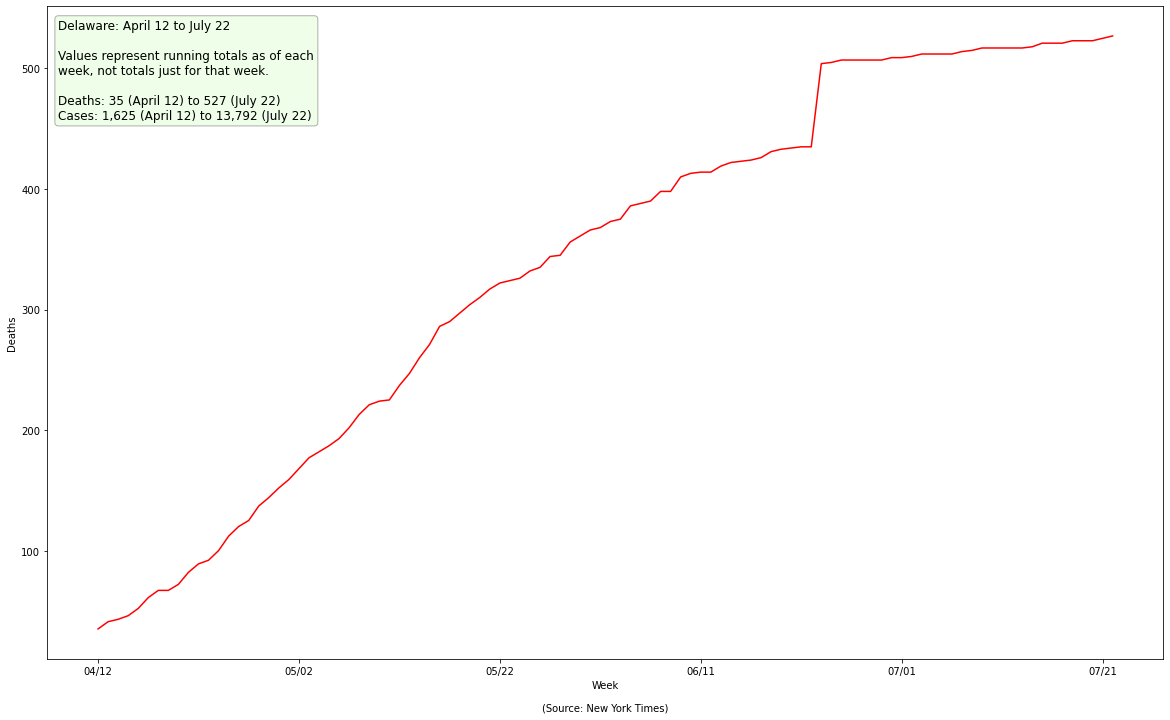

In [25]:
plot_state(df_states, 'Delaware', image_file='nyt-de-deaths.png', metrics={MetricType.DEATHS})

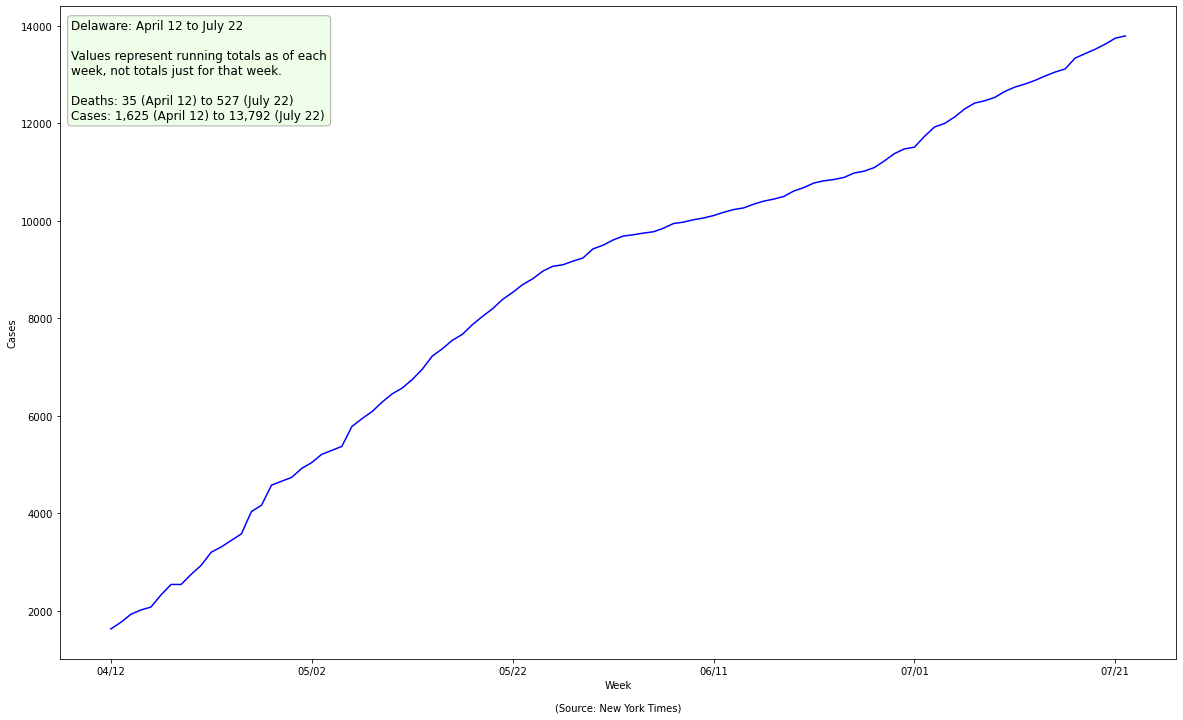

In [26]:
plot_state(df_states, 'Delaware', image_file='nyt-de-cases.png', metrics={MetricType.CASES})

### Texas

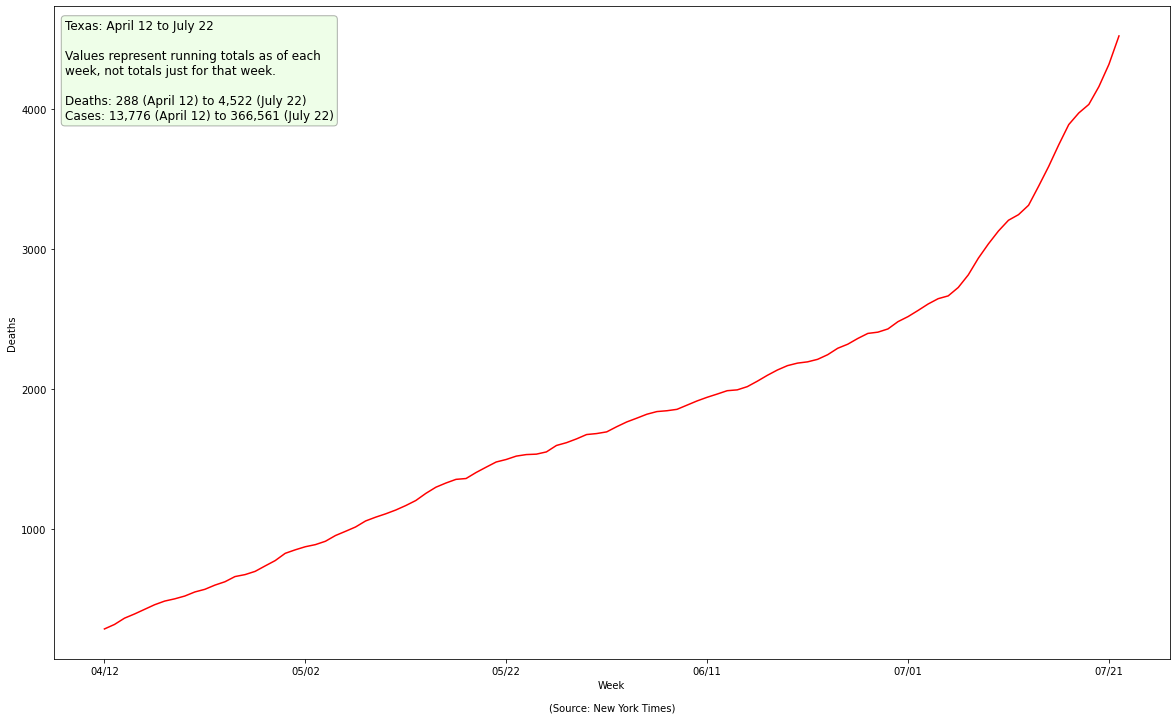

In [27]:
plot_state(df_states, 'Texas', image_file='nyt-tx-deaths.png', metrics={MetricType.DEATHS})

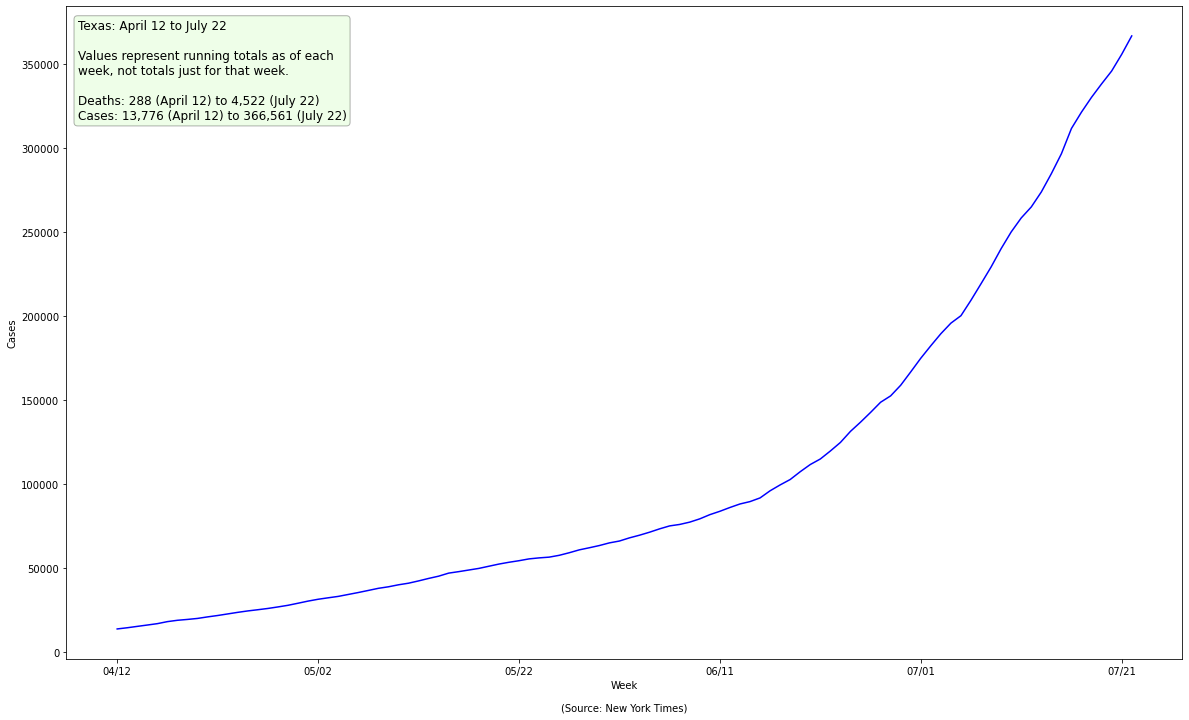

In [28]:
plot_state(df_states, 'Texas', image_file='nyt-tx-cases.png', metrics={MetricType.CASES})

### Georgia

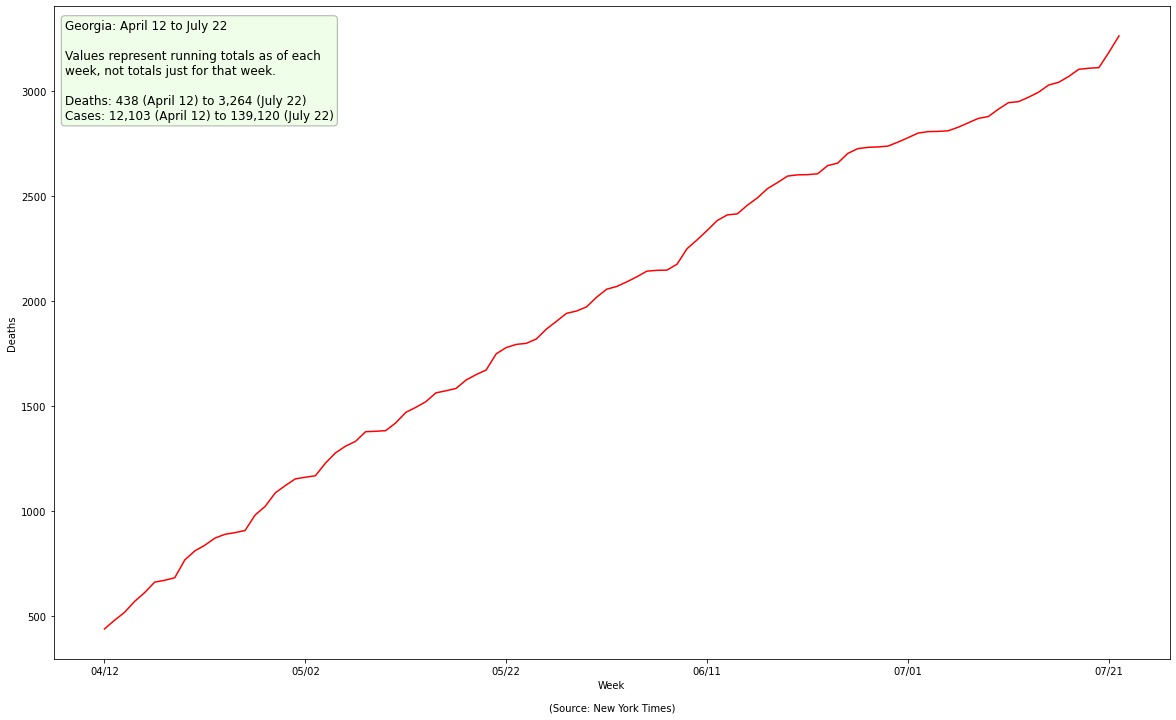

In [29]:
plot_state(df_states, 'Georgia', image_file='nyt-ga-deaths.png', metrics={MetricType.DEATHS})

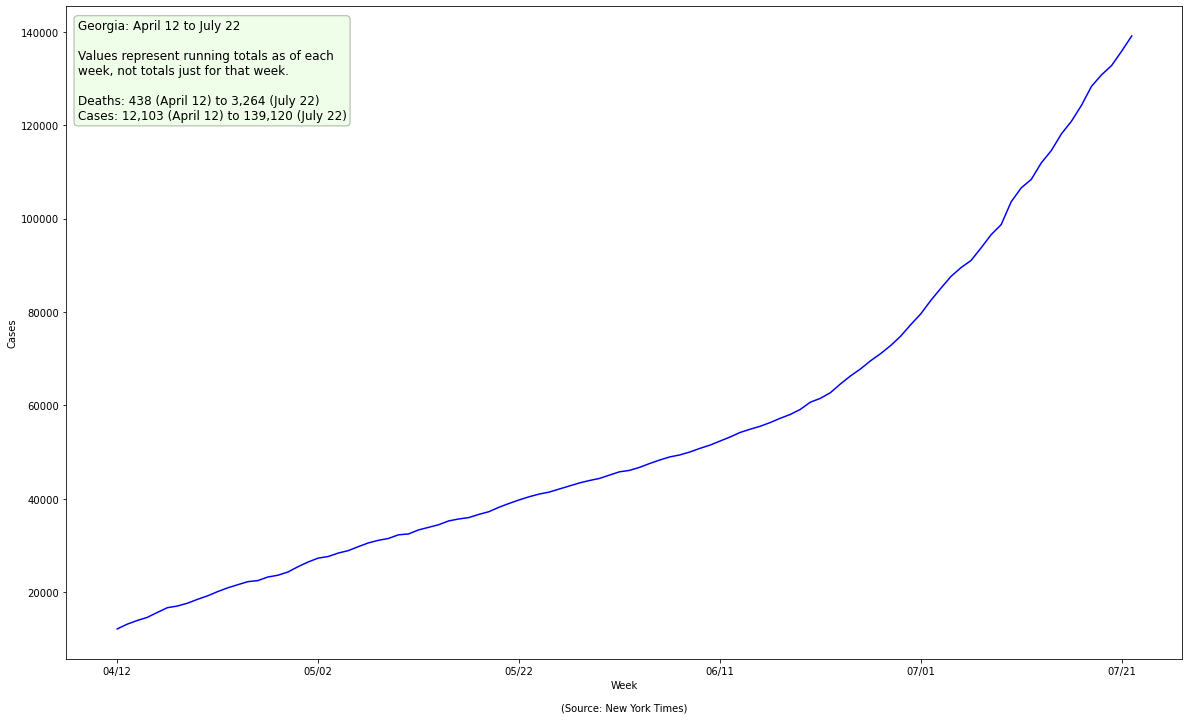

In [30]:
plot_state(df_states, 'Georgia', image_file='nyt-ga-cases.png', metrics={MetricType.CASES})

### Mississippi

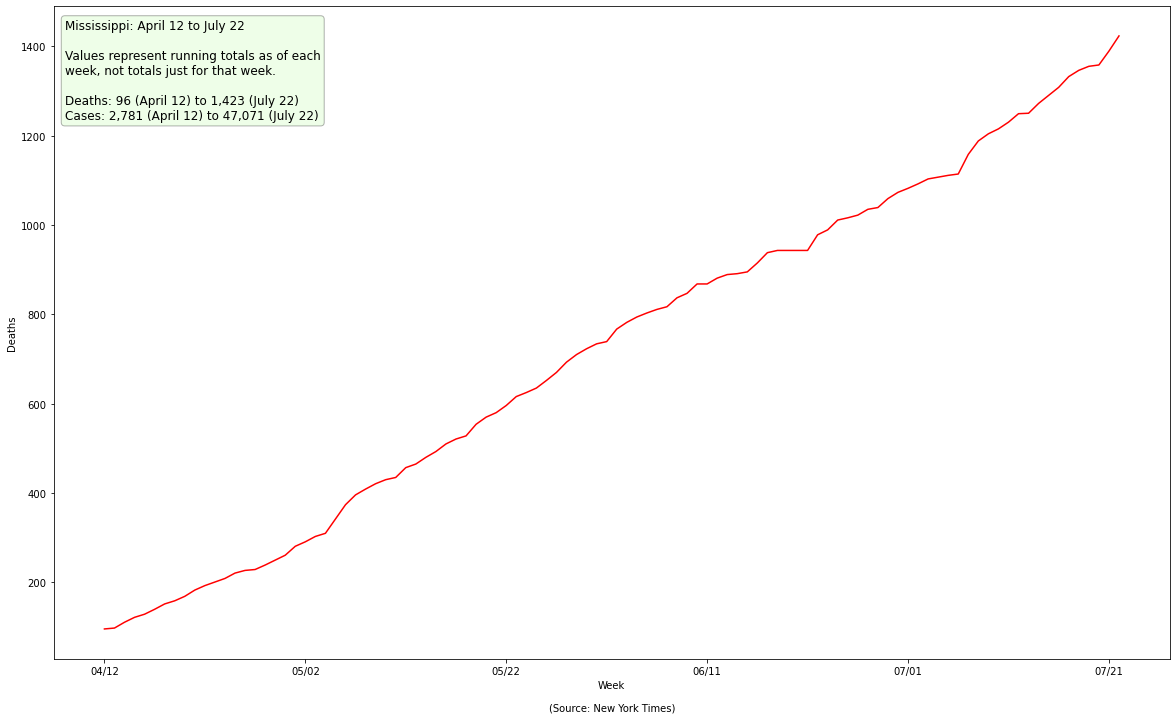

In [31]:
plot_state(df_states, 'Mississippi', image_file='nyt-ms-deaths.png', metrics={MetricType.DEATHS})

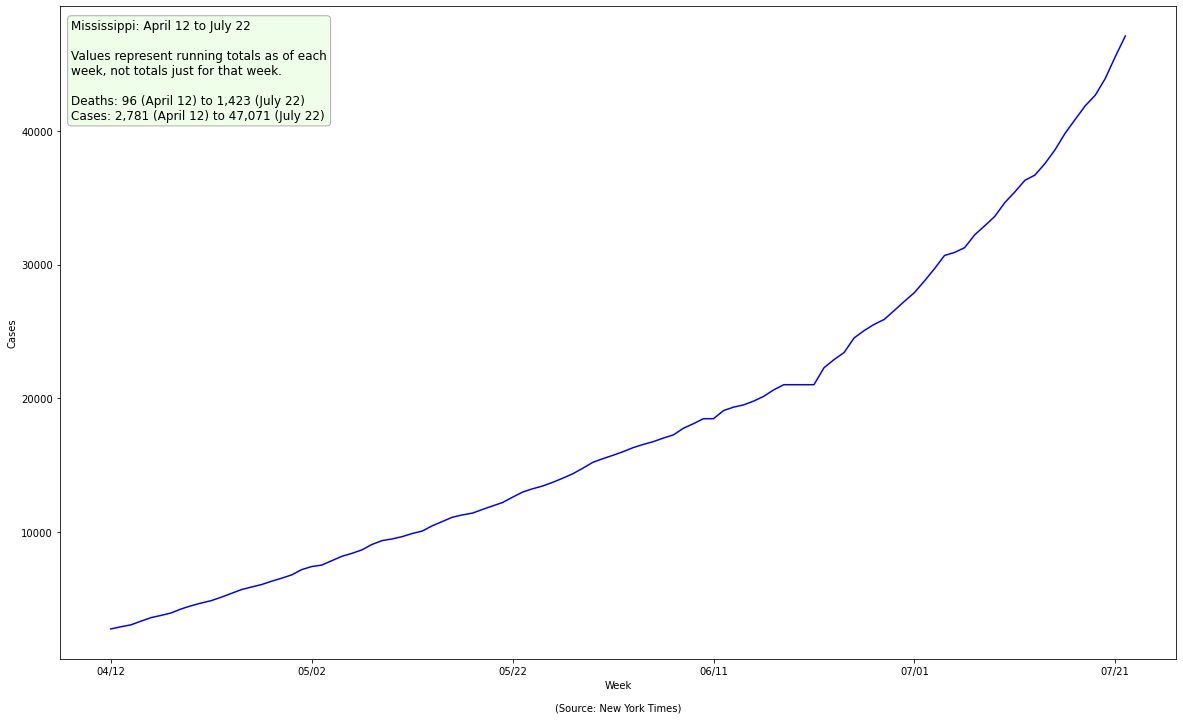

In [32]:
plot_state(df_states, 'Mississippi', image_file='nyt-ms-cases.png', metrics={MetricType.CASES})

### Arizona

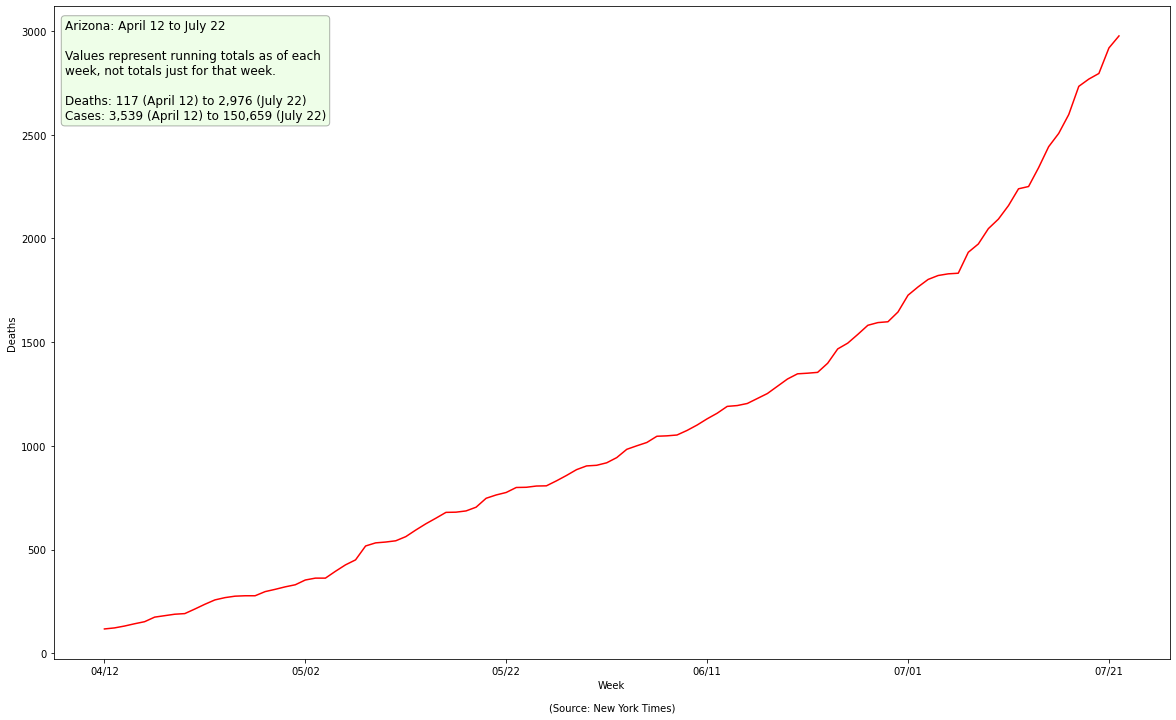

In [33]:
plot_state(df_states, 'Arizona', image_file='nyt-az-deaths.png', metrics={MetricType.DEATHS})

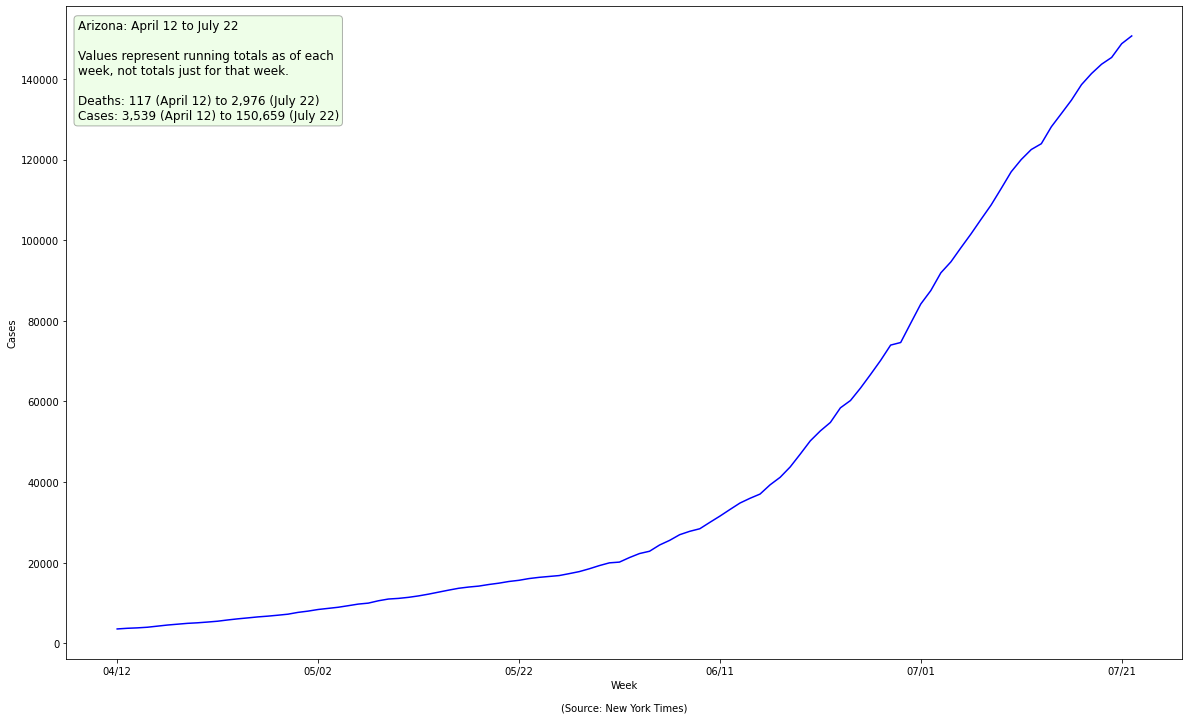

In [34]:
plot_state(df_states, 'Arizona', image_file='nyt-az-cases.png', metrics={MetricType.CASES})

### Multistate

In [35]:
def plot_states(df, states, metric=MetricType.DEATHS, per_n=1,
                populations=None, textbox_heading=None, textbox_loc=None, 
                figsize=(20, 12), legend_loc="lower right", image_file=None):
    """
    Takes a Pandas DataFrame with the Johns Hopkins data, and plots a particular
    metric once for each of a group of states, across all the dates in the
    DataFrame.
    
    Parameters:
    
    df              - The Pandas DataFrame from which to select the data.
    states          - The names of the states.
    metric          - The metric to plot. Defaults to deaths.
    per_n           - If set to 1, plot the data as is. Otherwise, do a per-capita
                      plot (i.e., number of X per n people). If per_n is not 1,
                      then population must be defined.
    populations     - The dictionary of populations per state. Only necessary
                      if per_n is greater than 1.
    figsize         - The size of the plot.
    textbox_heading - An optional heading to add to the textbox annotation
    textbox_loc     - An (x, y) tuple for the location of the text box's top
                      left corner. Defaults to the upper left.
    legend_loc      - Location of the legend, using matplotlib semantics. Defaults
                      to "lower right"
    image_file      - Name of image file in which to save plot, or None.
    """
    # Get a derived DataFrame with just the states passed in.
    # Also, we only care about the state, month_day, and
    # particular statistic column. Finally, ensure that the
    # resulting DataFrame is sorted by date, just in case the 
    # original was reordered.
    metric_col = METRIC_COLUMNS[metric]
    df2 = (df.loc[df.state.isin(states)][['state', 'month_day', metric_col]]
             .sort_values(by=['month_day'], inplace=False))
    if per_n > 1:
        func = lambda r: get_per_capita_float(r[metric_col], populations[r.state])
        df2[metric_col] = df2.apply(func, axis=1)

    # GROUP BY, SUM. Hello, SQL folks...
    group = df2.groupby(['month_day', 'state']).sum()
    
    # Unstack, to get each state's numbers in a separate column.
    final_df = group.unstack()

    fig, ax = p.subplots(figsize=figsize)

    # Let Pandas plot the whole thing.
    final_df.plot(ax=ax, kind='line', legend=True)

    # Set the X and Y axis labels. Add the credit below the X label,
    # since it's a nice place to stash it without interfering with
    # the plot.
    ax.set_xlabel('Week\n\n(Source: New York Times)')
    metric_label = METRIC_LABELS[metric]
    label = metric_label if per_n == 1 else f"{metric_label} per {per_n:,} people"
    ax.set_ylabel(label)

    # Add an explanatory text box.
    text_x, text_y = textbox_loc or (0.01, 0.987)
    heading = "" if textbox_heading is None else f"{textbox_heading}: "
    text_lines = [f"{heading}{label}\n"]
    for state in sorted(states):
        # Get the last value for the metric. It's the grand total.
        total = round(int(df2.loc[df2.state == state][metric_col].iloc[-1]))
        text_lines.append(f"{state}: {total:,}")
    textbox(ax, text_x, text_y, '\n'.join(text_lines))
    fix_pandas_multiplot_legend(ax, legend_loc)


### Northeast states

Data from some of the states that were hardest hit early on.

In [36]:
ne_states = ('Connecticut', 'New York', 'New Jersey', 'Pennsylvania', 'Delaware', 'Ohio')

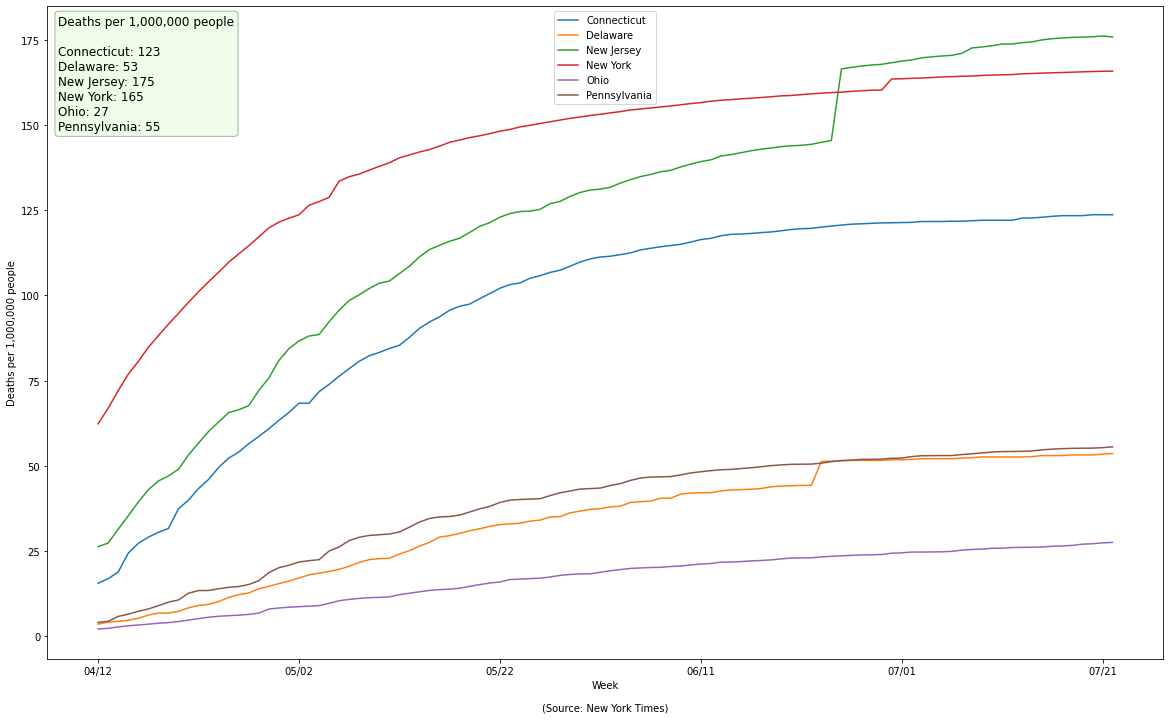

In [37]:
plot_states(df_states, ne_states, per_n=1_000_000, populations=populations, metric=MetricType.DEATHS,
            legend_loc='upper center')

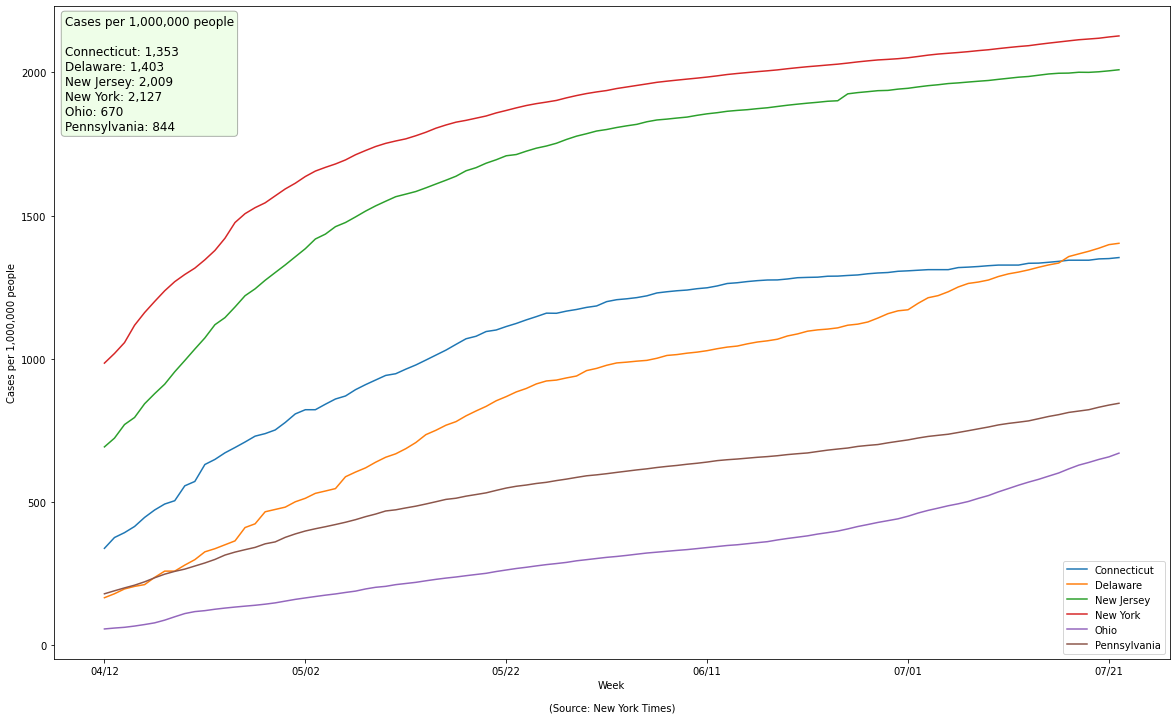

In [38]:
plot_states(df_states, ne_states, per_n=1_000_000, populations=populations, metric=MetricType.CASES,
            legend_loc='lower right')

### South and southwestern states

Data from some of the states hard hit in mid-2020.

In [39]:
s_sw_states = ('Arizona', 'Texas', 'Oklahoma', 'South Carolina', 'Utah', 'California', 'Florida')

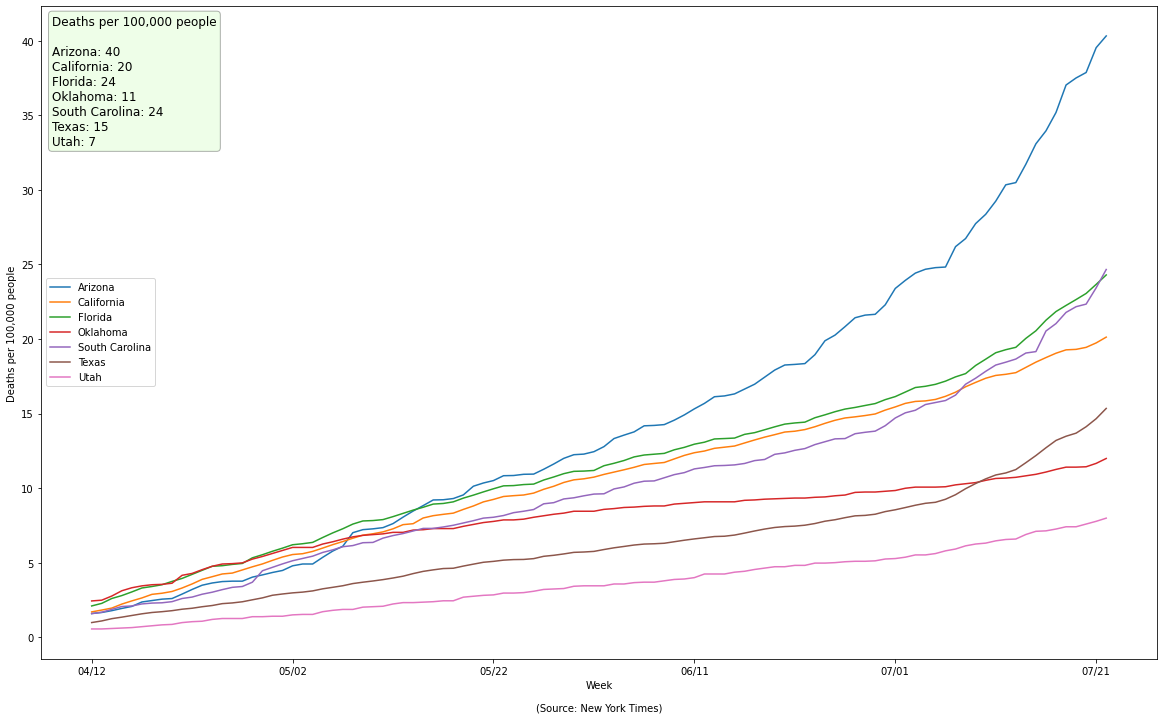

In [40]:
plot_states(df_states, s_sw_states, per_n=100_000, populations=populations, metric=MetricType.DEATHS,
            legend_loc='center left')

How are some of these states doing, compared to Pennsylvania (my home state)?

In [41]:
s_sw_plus_pa = s_sw_states + ('Pennsylvania',)

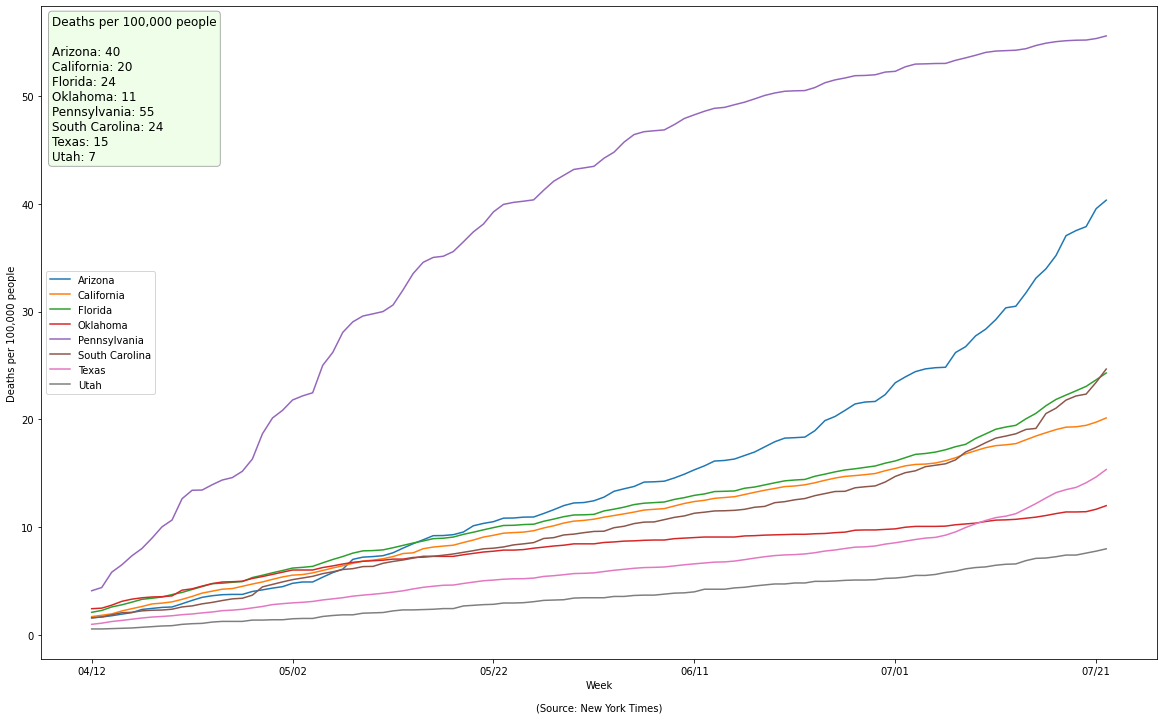

In [42]:
plot_states(df_states, s_sw_plus_pa, per_n=100_000, populations=populations, metric=MetricType.DEATHS,
            legend_loc='center left')

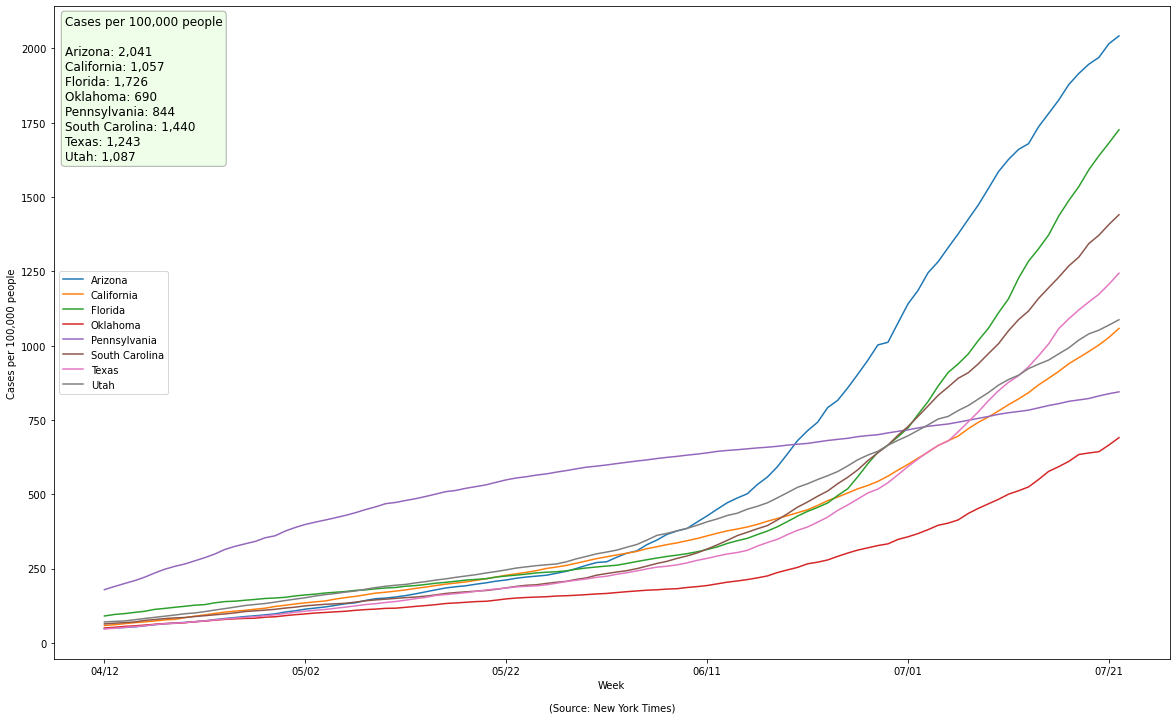

In [43]:
plot_states(df_states, s_sw_plus_pa, per_n=100_000, populations=populations, metric=MetricType.CASES,
            legend_loc='center left')

## Per-capita rates for all states

In [44]:
def plot_states_per_capita(df, populations, metric=MetricType.DEATHS,
                           figsize=(25, 12), show_us_per_capita=True,
                           per_n=1_000_000):
    """
    Plot a per-capita bar chart comparing all states, for a particular
    metric.
    
    Parameters:
    
    df                 - The Pandas DataFrame with the data.
    populations        - The loaded dictionary of populations.
    metric             - The metric to graph. Defaults to MetricType.DEATHS
    figsize            - The graph size. Defaults to 25x12
    show_us_per_capita - If True, show a line for the overall US per
                         capita value.
    per_n              - The per-capita factor. Must be 1,000 or larger.
    """
    fig, ax = p.subplots(figsize=figsize)
    metric_col = METRIC_COLUMNS[metric]
    color = METRIC_COLORS[metric]
    label = METRIC_LABELS[metric]

    assert per_n >= 1_000
    
    states = set(populations.keys()) - {'United States'}
    df_states = df.loc[df.state.isin(states)].sort_values(by=['date'], inplace=False)
    
    us_total = df_states[['state', metric_col]].groupby(['state']).max().sum()
    us_per_capita = get_per_capita_int(us_total, populations['United States'], per_n=per_n)

    df_states['per_capita'] = df_states.apply(
        lambda r: get_per_capita_float(r[metric_col], populations[r.state], per_n=per_n),
        axis=1
    )

    df_grouped = df_states[['state', 'per_capita']].groupby(['state']).max()

    # We're using zorder here to ensure that the horizontal line showing the
    # US per capita value shows up behind the bars.
    df_grouped.plot.bar(ax=ax, color=color, zorder=2, legend=False)
    if show_us_per_capita:
        ax.axhline(us_per_capita, color="lightgray", zorder=1)
        ax.set_yticks(ax.get_yticks() + [us_per_capita])

    # Set the X and Y axis labels. Add the credit below the X label,
    # since it's a nice place to stash it without interfering with
    # the plot.
    ax.set_xlabel("State\n\n(Source: New York Times)")
    ax.set_ylabel(f"{label} for {per_n:,} people")

    # See https://stackoverflow.com/a/25449186
    # (specifically, the first comment.)
    for patch in ax.patches:
        val = f"{round(int(patch.get_height())):,}"
        x = patch.get_x() + (patch.get_width() / 2)
        y = patch.get_height()
        ax.annotate(val, (x, y), ha='center', va='center', xytext=(0, 10), 
                    textcoords='offset points', zorder=2)

    if show_us_per_capita:
        text = f"U.S. {label} per {per_n:,} people: {us_per_capita:,}"
        textbox(ax, 0.01, 0.98, text)

    return (fig, ax)


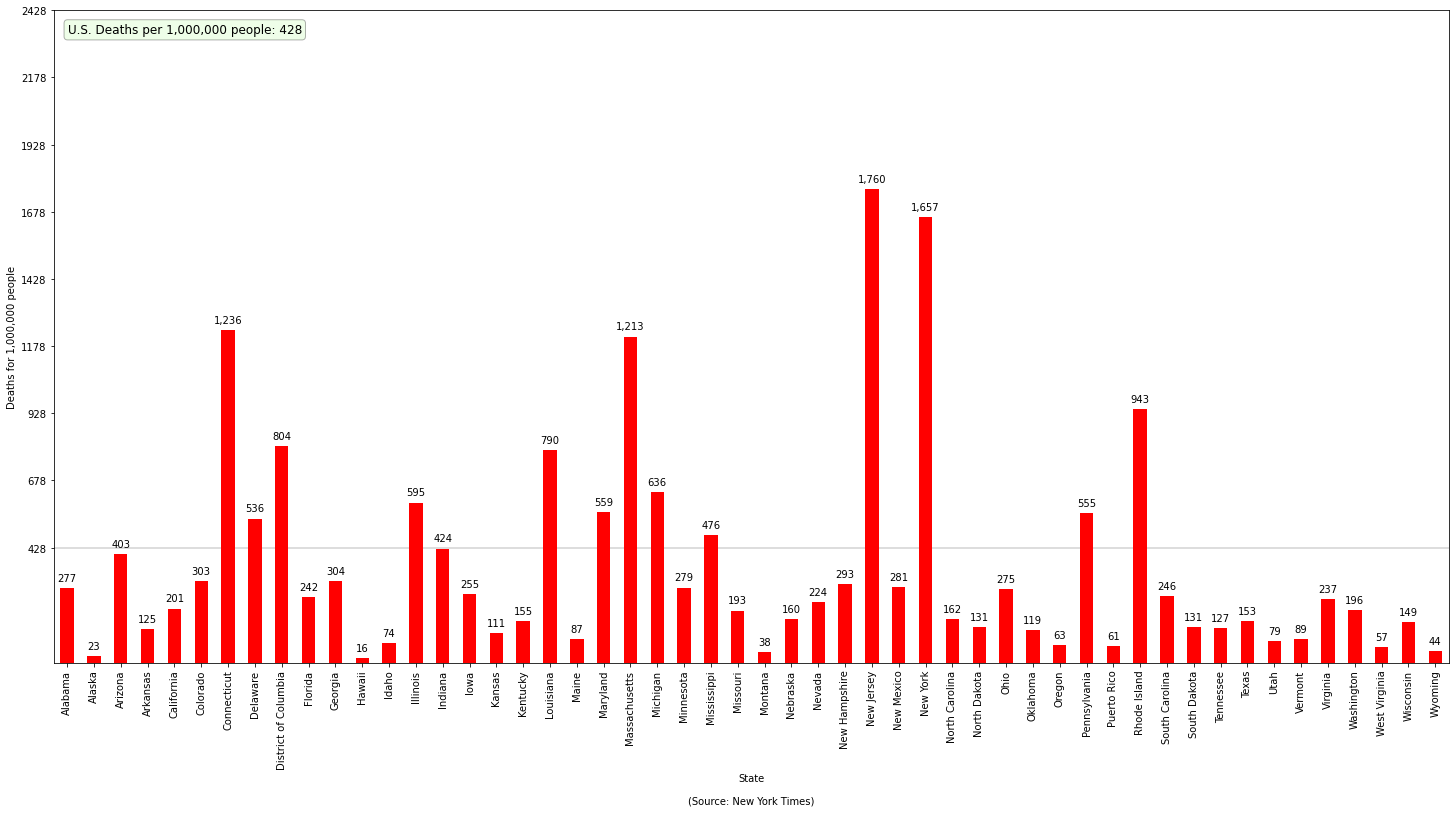

In [45]:
plot_states_per_capita(df_states, populations);

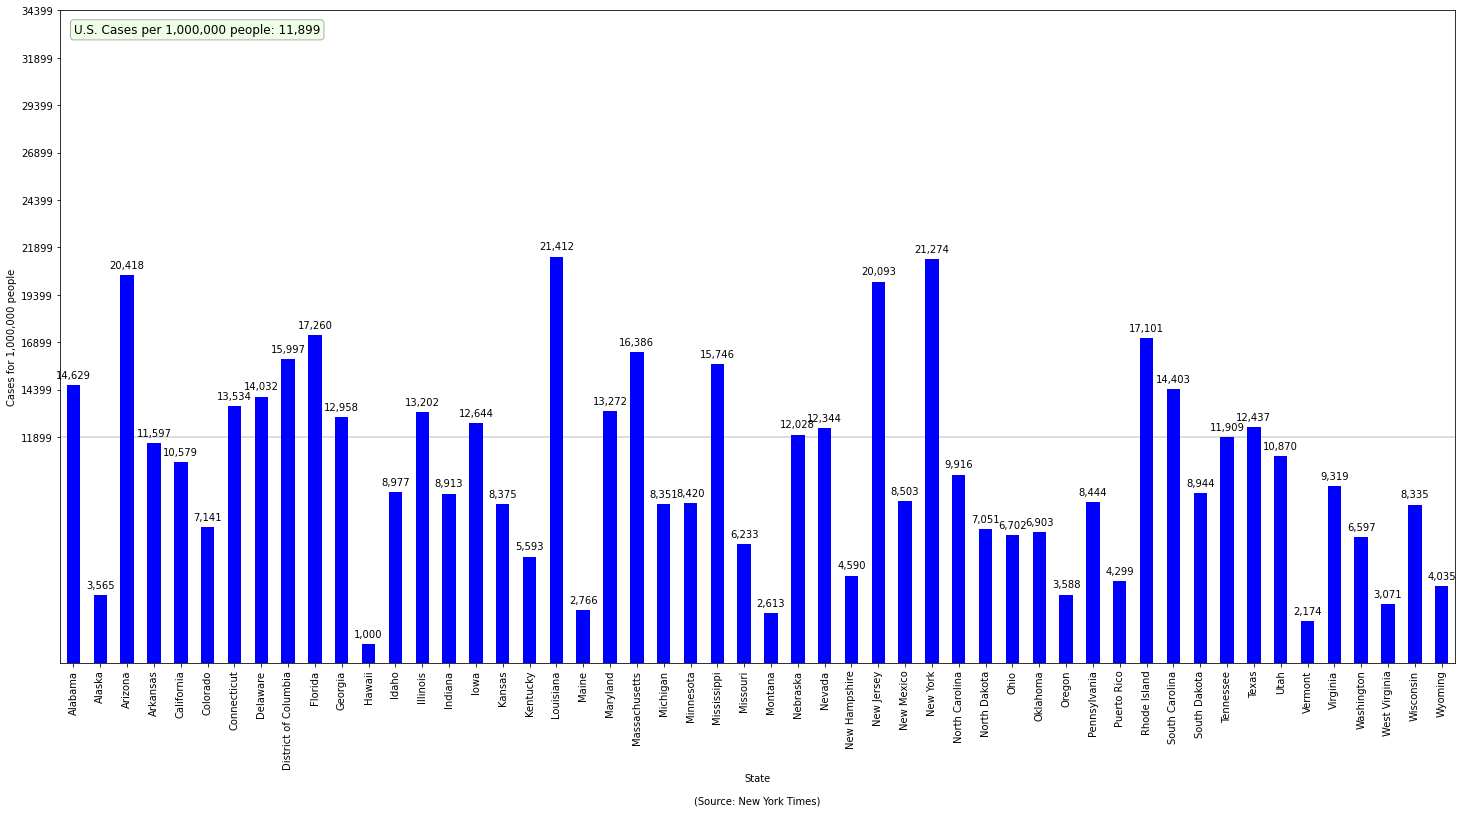

In [46]:
plot_states_per_capita(df_states, populations, metric=MetricType.CASES);

## Counties

In [47]:
def plot_counties(df, state, counties, metric=MetricType.DEATHS, image_file=None, 
                  textbox_loc=(0.01, 0.98), textbox_heading=None,
                  figsize=(20, 11), legend_loc='upper center'):
    """
    Plot a set of counties for a particular state.
    
    Parameters:
    
    df              - the DataFrame
    state           - The state name
    counties        - The counties within the state (by name)
    metric          - The metric to plot
    image_file      - Where to save the image, if any
    textbox_loc     - (x, y) coordinates of the info textbox
    textbox_heading - A heading to add to the textbox, or None
    figsize         - (width, height) of the plot
    legend_loc      - where to put the legend
    """
    metric_col = METRIC_COLUMNS[metric]
    cases_or_deaths = str(metric.name).capitalize()
    df2 = df.loc[df.county.isin(counties) & (df.state == state)][['month_day', 'county', metric_col]]
    group = df2.groupby(['month_day', 'county']).sum()

    # Unstack, to get each county's numbers in a separate column.
    final_df = group.unstack()

    fig, ax = p.subplots(figsize=figsize)

    # Let Pandas plot the whole thing.
    final_df.plot(ax=ax, kind='line', legend=True)

    # Set the X and Y axis labels. Add the credit below the X label,
    # since it's a nice place to stash it without interfering with
    # the plot.
    ax.set_xlabel('Week\n\n(Source: New York Times)')
    metric_label = METRIC_LABELS[metric]
    ax.set_ylabel(metric_label)

    # Add an explanatory text box.
    text_x, text_y = textbox_loc or (0.01, 0.987)
    heading = f"{state} county {metric_label.lower()}"
    text_lines = [f"{heading}"]
    if textbox_heading:
        text_lines.append(textbox_heading)
    text_lines.append("")
    for county in sorted(counties):
        # Get the last value for the metric. It's the grand total.
        total = round(int(df2.loc[df2.county == county][metric_col].iloc[-1]))
        text_lines.append(f"{county}: {total:,}")

    textbox(ax, text_x, text_y, '\n'.join(text_lines))
    fix_pandas_multiplot_legend(ax, legend_loc)

    if image_file is not None:
        fig.savefig(os.path.join(IMAGES_PATH, image_file))


### Some select Pennsylvania counties

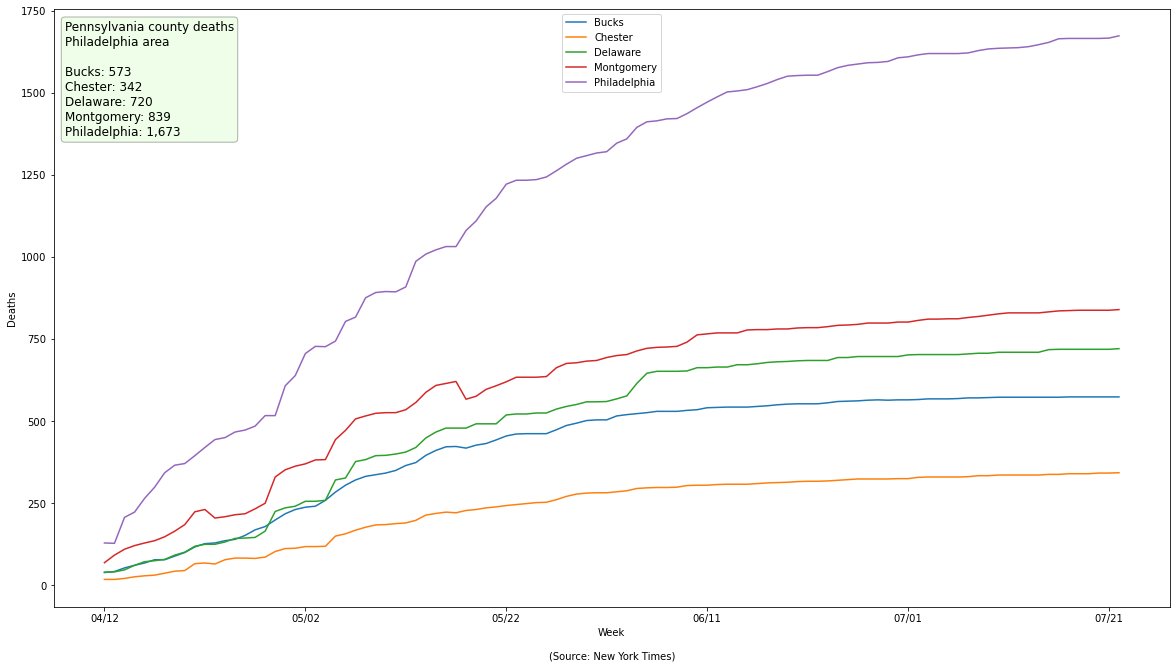

In [48]:
philly_area_counties = ('Montgomery', 'Philadelphia', 'Chester', 'Bucks', 'Delaware')
plot_counties(df_counties, 'Pennsylvania', philly_area_counties, textbox_heading="Philadelphia area",
              metric=MetricType.DEATHS, image_file='nyt-pa-phl-area-deaths.png')

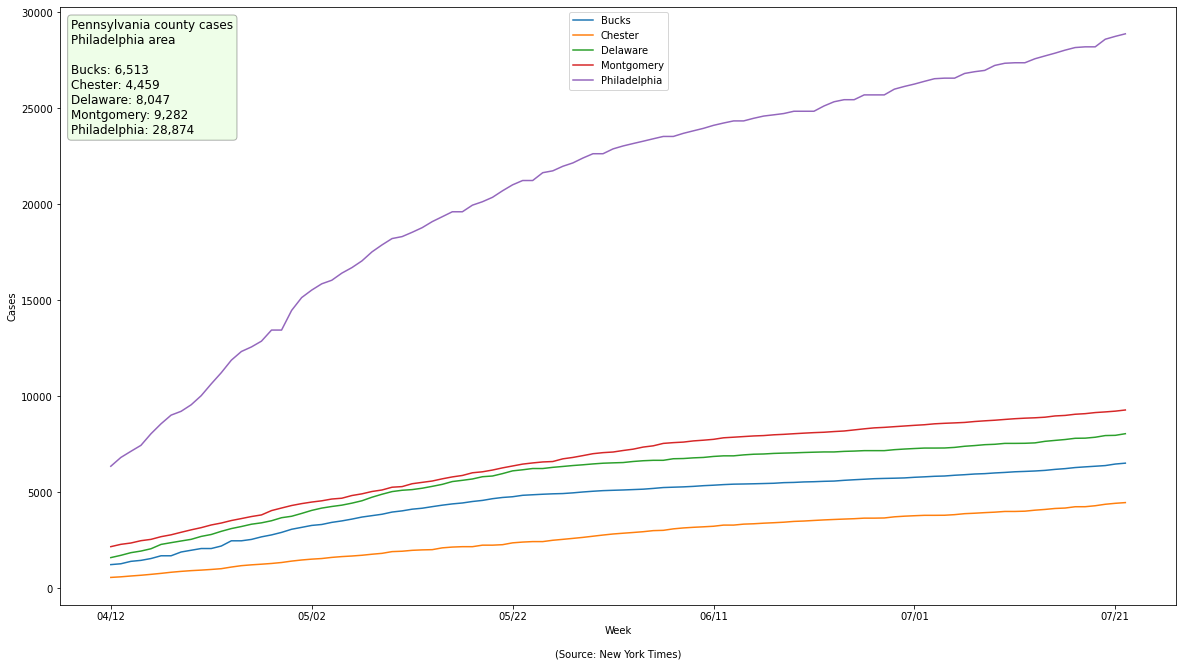

In [49]:
plot_counties(df_counties, 'Pennsylvania', philly_area_counties, textbox_heading="Philadelphia area",
              metric=MetricType.CASES, image_file='nyt-pa-phl-area-cases.png')

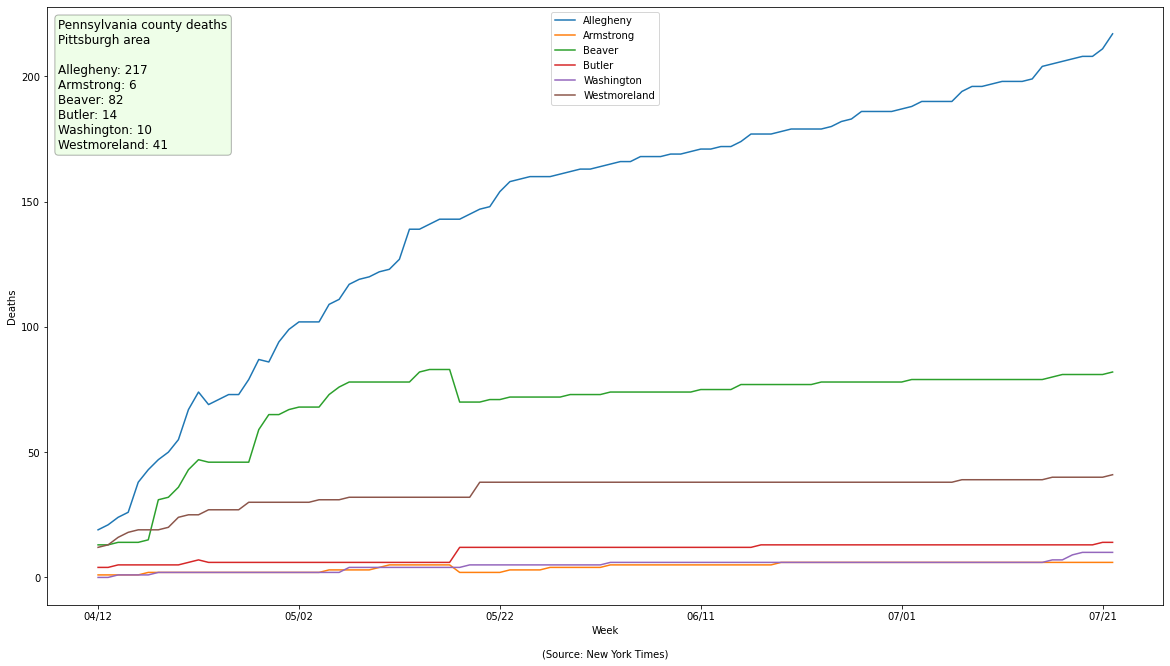

In [50]:
pgh_area_counties = ('Allegheny', 'Butler', 'Beaver',
                     'Washington', 'Westmoreland', 'Armstrong')
plot_counties(df_counties, 'Pennsylvania', pgh_area_counties, textbox_heading="Pittsburgh area",
              metric=MetricType.DEATHS, image_file='nyt-pgh-area-deaths.png')

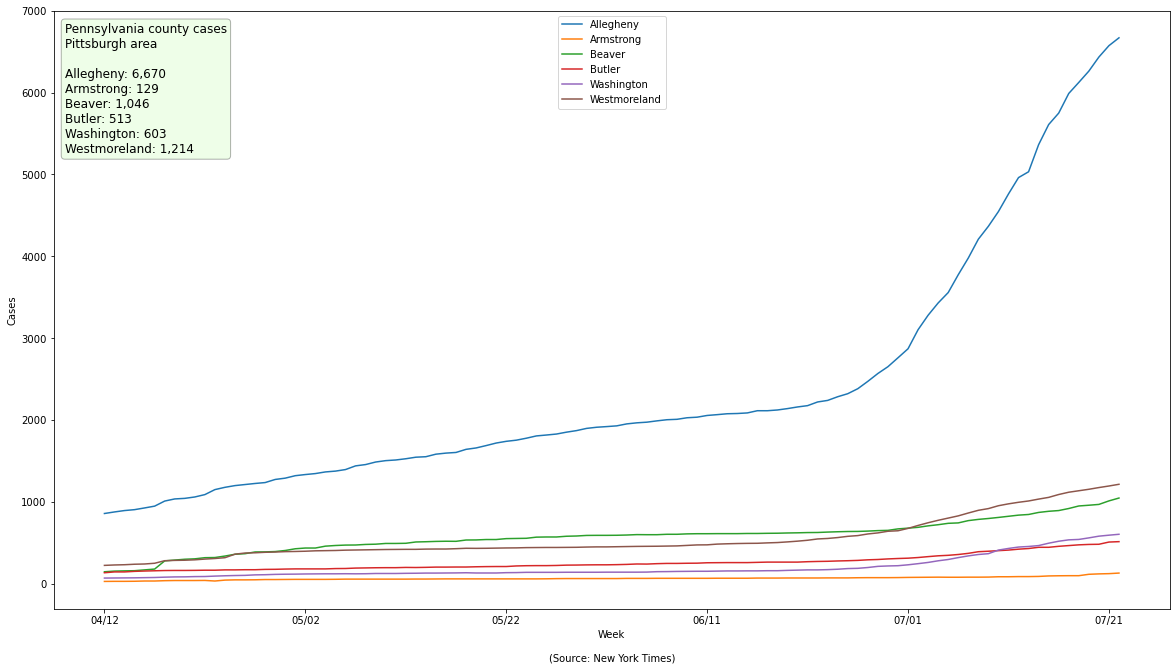

In [51]:
plot_counties(df_counties, 'Pennsylvania', pgh_area_counties, textbox_heading="Pittsburgh area",
              metric=MetricType.CASES, image_file='nyt-pgh-area-cases.png')

## Florida 

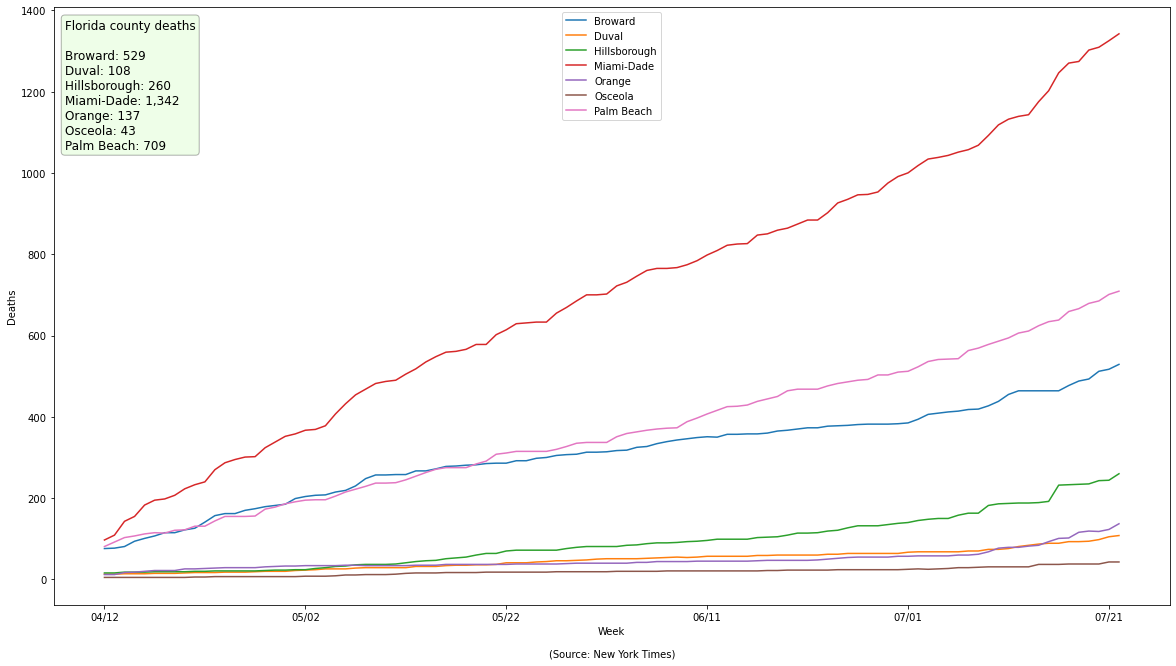

In [52]:
# Osceola and Orange are near Orlando.
# Hillsborough contains Tampa.
# Broward and Palm Beach are near Miami.
# Duval contains Jacksonville.
fl_counties = ('Osceola', 'Orange', 'Miami-Dade', 'Palm Beach',
               'Broward', 'Hillsborough', 'Duval')
plot_counties(df_counties, 'Florida', fl_counties, 
              image_file='nyt-fl-county-deaths.png', metric=MetricType.DEATHS)

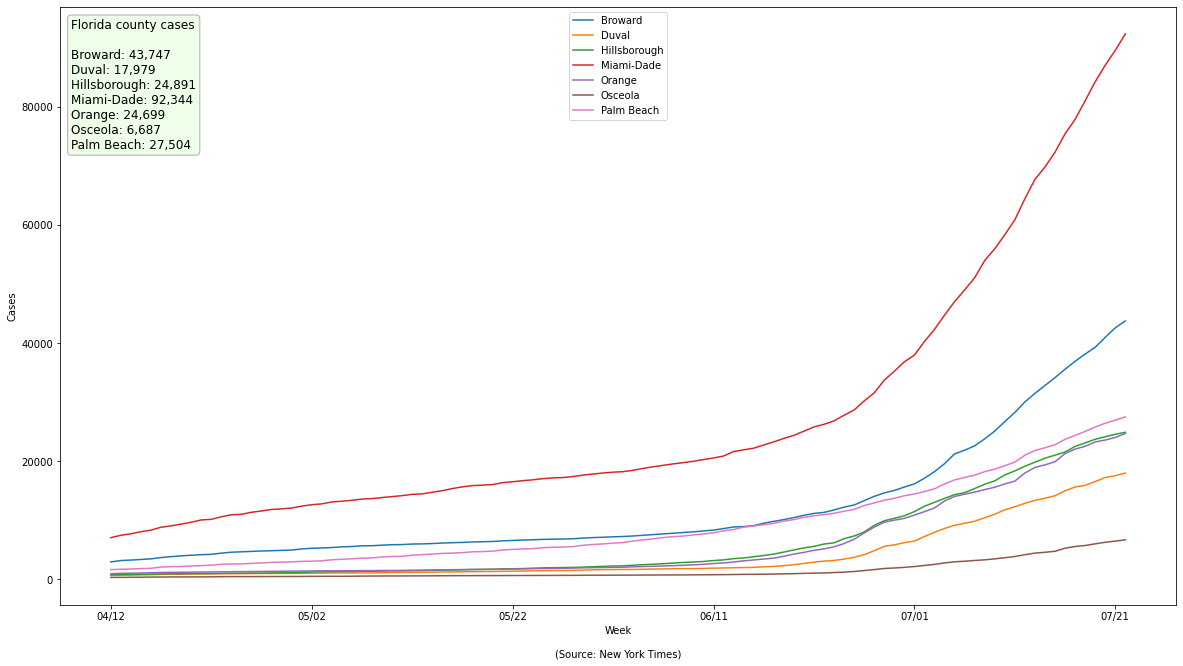

In [53]:
plot_counties(df_counties, 'Florida', fl_counties, 
              image_file='nyt-fl-county-cases.png', metric=MetricType.CASES)